# Load Dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
from torch.distributions import Normal, Independent, Categorical

import numpy as np
import matplotlib.pyplot as plt
import tqdm
import math
import os

from modules import *

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist_train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [3]:
class BouncingBallDataLoader(Dataset):

    def __init__(self, root_dir):
        if isinstance(root_dir,str):
            self.root_dir = root_dir
            self.file_list = sorted(os.listdir(root_dir))
            self.multiple = False
            self.filenames = None
        else:
            self.root_dir = root_dir
            self.file_list = []
            for dir in root_dir:
                for filename in sorted(os.listdir(dir)):
                    self.file_list.append(os.path.join(dir,filename))
            self.multiple = True

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, i):
        sample = np.load(os.path.join(
            self.root_dir, self.file_list[i])) if not self.multiple else np.load(self.file_list[i])
        im = sample['arr_0']
        if len(im.shape) == 3:
            im = im[:,np.newaxis,:,:]
        else:
            im = im.astype(float)
            if im.max() > 2.0:
                im /= 255.0
            im = im.transpose((0,3,1,2)) - 0.5
        return (im,)

In [4]:
seed = 24 # 23 24 25 26 27
num_states = 3
dim_obs = 2
dim_latent = 2
T = 20
data_size = 5000
sparsity_prob = 0.0
data_type = 'cosine'

path = "../../../vol/bitbucket/am9923/datasets/latent_variables_im/images_train_N_{}_T_{}_dim_latent_{}_dim_obs_{}_state_{}_sparsity_{}_net_{}_seed_{}/".format(data_size,T, dim_latent, dim_obs, num_states, sparsity_prob, data_type, seed)
test_path = "../../../vol/bitbucket/am9923/datasets/latent_variables_im/images_test_N_{}_T_{}_dim_latent_{}_dim_obs_{}_state_{}_sparsity_{}_net_{}_seed_{}/".format(data_size//10,T, dim_latent, dim_obs, num_states, sparsity_prob, data_type, seed)

dl = BouncingBallDataLoader(path)
test_dl = BouncingBallDataLoader(test_path)

train_dataloader = DataLoader(dl, batch_size=32, shuffle=True) 
test_dataloader = DataLoader(test_dl, batch_size=64, shuffle=False)

In [5]:
np.min(train_dataloader.dataset[0][0]+0.5), np.max(train_dataloader.dataset[0][0]+0.5)

(0.31764705882352934, 0.996078431372549)

In [6]:
def imshow_grid(images, n_row=8, n_col=8, title="", fig_size_a=10, fig_size_b=10):
    # fig_size_a is width
    # fig_size_b is length    
    fig, axes = plt.subplots(n_row, n_col, figsize=(fig_size_a, fig_size_b))
    fig.suptitle(title)
    for i in range(n_row):
        for j in range(n_col):
            axes[i, j].imshow((np.transpose(images[i,j],(1,2,0))+0.5))
            axes[i, j].axis('off')
    plt.show()

# Visualise

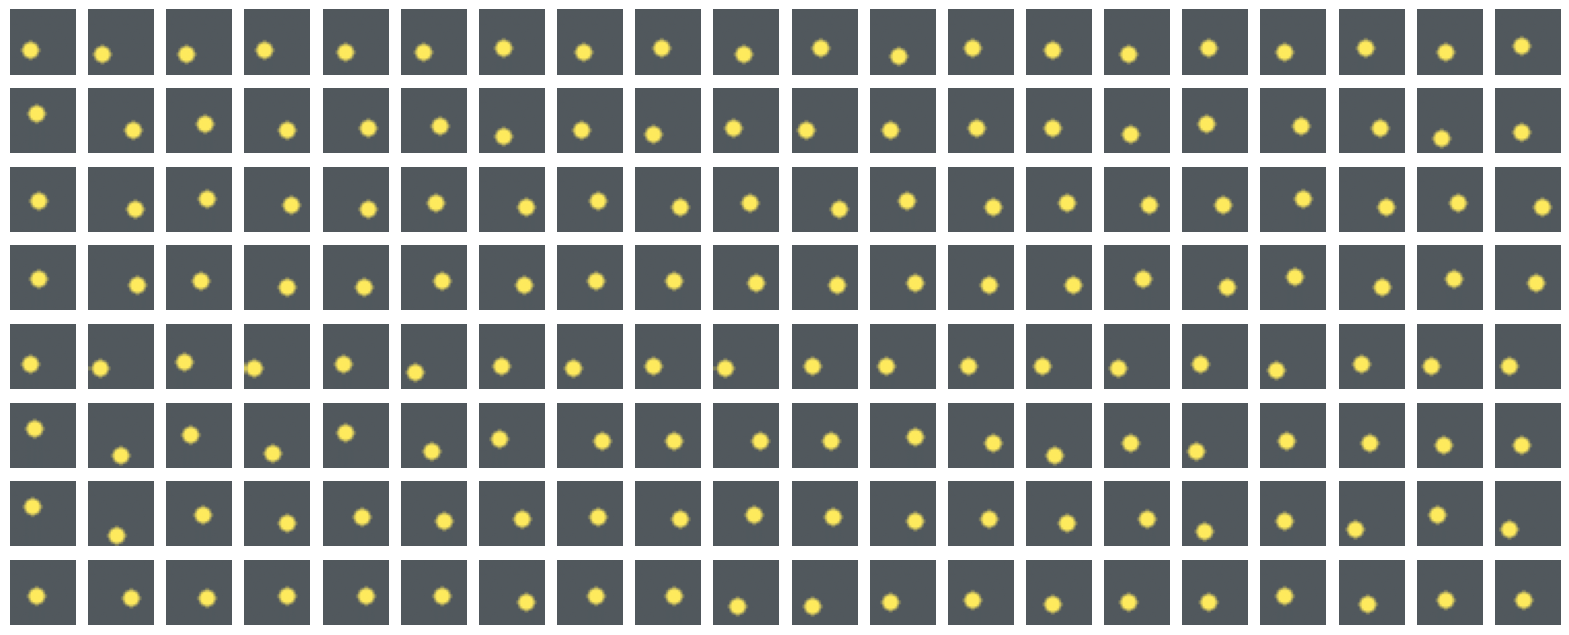

In [7]:
# Visualize a batch of training data
(batch_images,) = next(iter(train_dataloader))
imshow_grid(batch_images[0:8],n_col=20,fig_size_a=20, fig_size_b=8)  # Displaying the first batch

In [8]:
torch.min(batch_images), torch.max(batch_images)

(tensor(-0.1824, dtype=torch.float64), tensor(0.4961, dtype=torch.float64))

In [9]:
batch_images.shape

torch.Size([32, 20, 3, 32, 32])

# Create the VRNN

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
!nvidia-smi

Thu Aug 29 15:11:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:B5:00.0 Off |                    0 |
| N/A   39C    P8              10W /  70W |      5MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
class VRNN(nn.Module):
    def __init__(self, h_dim, z_dim, beta=1, constant_logvar=True):
        super().__init__()
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.beta = beta
        self.constant_logvar = constant_logvar
        
        # Feature extractors
        self.phi_x = nn.Sequential(
                        nn.Conv2d(3, 32, kernel_size= 3, stride= 2, padding  = 1),
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),

                        nn.Conv2d(32, 64, kernel_size= 3, stride= 2, padding  = 1),
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU(),

                        nn.Conv2d(64, 128, kernel_size= 3, stride= 2, padding  = 1),
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(),

                        nn.Conv2d(128, 256, kernel_size= 3, stride= 2, padding  = 1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(),

                        nn.Conv2d(256, 512, kernel_size= 3, stride= 2, padding  = 1),
                        nn.BatchNorm2d(512),
                        nn.LeakyReLU(),            
                        nn.Flatten(),
                
                        nn.Linear(512, h_dim)
        )
        
        self.phi_z = nn.Sequential(
                        nn.Linear(z_dim, h_dim),
                        nn.ReLU())        
        
        # Prior distribution
        self.prior = nn.Sequential(
                        nn.Linear(h_dim, h_dim),
                        nn.ReLU())

        self.prior_mean = nn.Linear(h_dim, z_dim)
        self.prior_logvar = nn.Linear(h_dim, z_dim)
        
        
        # Encoder
        self.encoder = nn.Sequential(
                        nn.Linear(h_dim + h_dim, h_dim),
                        nn.ReLU(),
                        nn.Linear(h_dim, h_dim),
                        nn.ReLU())
        
        self.mu_layer = nn.Linear(h_dim, z_dim)
        self.logvar_layer = nn.Linear(h_dim, z_dim)
        
        # Decoder
        self.decoder_linear = nn.Linear(2 * h_dim, 512)
        self.decoder = nn.Sequential(
                         nn.ConvTranspose2d(8,64,kernel_size=3,stride=1,padding=1), # [8,8,8] --> [64,8,8]
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(),
        
                         nn.ConvTranspose2d(64,64,kernel_size=3,stride=1,padding=1),
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(),
            
                         nn.ConvTranspose2d(64,64,kernel_size=3,stride=2,padding=1, output_padding=1), # [64,8,8] --> [64,16,16]
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(),
            
                         nn.ConvTranspose2d(64,64,kernel_size=3,stride=1,padding=1), 
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(),
        
                         nn.ConvTranspose2d(64,64,kernel_size=3,stride=1,padding=1),
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(),

                         nn.ConvTranspose2d(64,64,kernel_size=3,stride=2,padding=1, output_padding=1), # [64,16,16] --> [64,32,32]
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(),                         
                                                                                                                                                                                                                                            
            
                         #nn.Conv2d(32,1,kernel_size= 3, padding= 1),
                         #nn.Sigmoid()           
        )
        self.decoder_mean = nn.Sequential(
                         nn.Conv2d(64,3,kernel_size= 3, padding= 1),
                         nn.Sigmoid()                        
        )
        self.decoder_logvar = torch.tensor(5e-4,device=device)
        
        
        # Recurrence
        self.rnn = nn.GRU(h_dim + h_dim, h_dim)
        
    def reparametrize(self, mu, logvar):
        epsilon = torch.randn_like(logvar)
        z_reparametrized = mu + torch.exp(logvar/2) * epsilon
        return z_reparametrized
    
    def forward(self, x):
        (B,T,*_) = x.shape
        loss = torch.ones((T,B))
        recons = torch.zeros(B, T, 3, 32, 32)
        
        h = torch.zeros((1, B, self.h_dim), device=device)
        for t in range(T):
            # Prior
            prior_t = self.prior(h[0])
            prior_mean_t = self.prior_mean(prior_t)
            prior_std_t = self.prior_logvar(prior_t)            
            
            # Extract features
            phi_x_t = self.phi_x(x[:,t])
            
            # Encode
            enc_t = self.encoder(torch.cat([phi_x_t, h[0]], 1))
            enc_mean_t = self.mu_layer(enc_t)
            enc_std_t = self.logvar_layer(enc_t)
            
            # Sample
            z_t = self.reparametrize(enc_mean_t, enc_std_t)
            
            # Extract features
            phi_z_t = self.phi_z(z_t)
            
            # Decode (we use the mean, could create a Normal distribution here and sample from it)
            recon_x = self.decoder_linear(torch.cat([phi_z_t, h[0]], 1))
            
            recon_x = recon_x.view(-1, 8, 8, 8)
            recon_x = self.decoder(recon_x)
            recon_x = self.decoder_mean(recon_x)
            recons[:,t] = recon_x

            # Update h
            _, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)            
            
            # Update losses     
            loss[t] = loss_function(recon_x, x[:,t], enc_mean_t, enc_std_t, prior_mean_t, prior_std_t, self.beta)

        total_loss = (loss).sum(axis=0).mean()   
            
        return total_loss, recons
    
    def sample(self, seq_len = 8, n_samples = 10):
        samples = torch.zeros((n_samples, seq_len, 3, 32, 32))
        self.eval()
        for i in range(n_samples):
            with torch.inference_mode():
                sample = torch.zeros(seq_len, 3, 32, 32, device=device)
                h = torch.zeros(1, 1, self.h_dim, device=device)
                for t in range(seq_len):
                    # Prior
                    prior_t = self.prior(h[0])
                    prior_mean_t = self.prior_mean(prior_t)
                    prior_logvar_t = self.prior_logvar(prior_t)
                    # Sample
                    z_t = self.reparametrize(prior_mean_t, prior_logvar_t)
                    
                    # Extract Features
                    phi_z_t = self.phi_z(z_t)

                    # Decode
                    sample_t = self.decoder_linear(torch.cat([phi_z_t, h[0]], 1))
                    sample_t = sample_t.view(-1, 8, 8, 8)
                    sample_t = self.decoder(sample_t)
                    sample_t = self.decoder_mean(sample_t)

                    phi_x_t = self.phi_x(sample_t)

                    #recurrence
                    _, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

                    sample[t] = sample_t.data
            samples[i] = sample.cpu()
        return samples

    def predict_sequence(self, x, seq_len=None):
        # Input [B,3,3,32,32]
        (B, T, C, H, W) = x.size()

        h = torch.zeros((1, B, self.h_dim), device=device)
        for t in range(T):          
            # Extract features
            phi_x_t = self.phi_x(x[:,t])
            
            # Encode
            enc_t = self.encoder(torch.cat([phi_x_t, h[0]], 1))
            enc_mean_t = self.mu_layer(enc_t)
            enc_std_t = self.logvar_layer(enc_t)
            
            # Sample
            z_t = self.reparametrize(enc_mean_t, enc_std_t)
            
            # Extract features
            phi_z_t = self.phi_z(z_t)
            
            # Update h
            _, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

        samples = torch.zeros((B, seq_len, C, H, W))

        for t in range(seq_len):
            # Prior
            prior_t = self.prior(h[0])
            prior_mean_t = self.prior_mean(prior_t)
            prior_logvar_t = self.prior_logvar(prior_t)
            # Sample
            z_t = self.reparametrize(prior_mean_t, prior_logvar_t)
            
            # Extract Features
            phi_z_t = self.phi_z(z_t)

            # Decode
            sample_t = self.decoder_linear(torch.cat([phi_z_t, h[0]], 1))
            sample_t = sample_t.view(-1, 8, 8, 8)
            sample_t = self.decoder(sample_t)
            sample_t = self.decoder_mean(sample_t)

            phi_x_t = self.phi_x(sample_t)

            samples[:,t] = sample_t

            #recurrence
            _, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

        return samples

    def iwae(self,x,N):
        B = x.shape[0]
        T = x.shape[1]
        C = x.shape[2]
        H = x.shape[3]
        W = x.shape[4]
        # Similar to https://github.com/ZoneMS/EnKO/blob/main/SVAE/model/vrnn.py
        inputs = x.unsqueeze(1).repeat(1,N,1,1,1,1) # [B,T,C,H,W] --> [B,P,T,C,H,W]
        # Reshape so it passes through conv2d layers
        inputs = inputs.reshape((B*N,T,C,H,W))
        loss = torch.ones((T,N,B))
        h = torch.zeros((1, B*N, self.h_dim), device=device, dtype=x.dtype)
        for t in range(T):
            # Prior
            prior_t = self.prior(h[0])
            prior_mean_t = self.prior_mean(prior_t)
            prior_std_t = self.prior_logvar(prior_t)            
            
            # Extract features
            phi_x_t = self.phi_x(inputs[:,t])
            
            # Encode
            enc_t = self.encoder(torch.cat([phi_x_t, h[0]], 1))
            enc_mean_t = self.mu_layer(enc_t)
            enc_std_t = self.logvar_layer(enc_t)
            
            # Sample
            z_t = self.reparametrize(enc_mean_t, enc_std_t)

            # Extract features
            phi_z_t = self.phi_z(z_t)
            
            # Decode (we use the mean, could create a Normal distribution here and sample from it)
            recon_x = self.decoder_linear(torch.cat([phi_z_t, h[0]], 1))
            recon_x = recon_x.view(-1, 8, 8, 8)
            recon_x = self.decoder(recon_x)
            dec_mean_t = self.decoder_mean(recon_x)

            # Update h
            _, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

            # Calculate loss
            loss_t = loss_function(dec_mean_t, inputs[:,t], enc_mean_t, enc_std_t, prior_mean_t, prior_std_t, self.beta)

            # Change logprobs to appropriate dimensions and save them
            loss_t = loss_t.reshape((B,N)).transpose(1,0) # shape is now [N,B]

            loss[t] = loss_t

        logW = logsumexp((-loss).sum(axis=0), axis=0).mean() - math.log(N)
        return logW, (loss)
        

    def fivo(self,x,N):
        B = x.shape[0]
        T = x.shape[1]
        C = x.shape[2]
        H = x.shape[3]
        W = x.shape[4]
        # Similar to https://github.com/ZoneMS/EnKO/blob/main/SVAE/model/vrnn.py
        inputs = x.unsqueeze(1).repeat(1,N,1,1,1,1) # [B,T,C,H,W] --> [B,P,T,C,H,W]
        # Reshape so it passes through conv2d layers
        inputs = inputs.reshape((B*N,T,C,H,W))
        loss = torch.ones((T,N,B))
        h = torch.zeros((1, B*N, self.h_dim), device=device, dtype=x.dtype)
        for t in range(T):
            # Prior
            prior_t = self.prior(h[0])
            prior_mean_t = self.prior_mean(prior_t)
            prior_std_t = self.prior_logvar(prior_t)            
            
            # Extract features
            phi_x_t = self.phi_x(inputs[:,t])
            
            # Encode
            enc_t = self.encoder(torch.cat([phi_x_t, h[0]], 1))
            enc_mean_t = self.mu_layer(enc_t)
            enc_std_t = self.logvar_layer(enc_t)
            
            # Sample
            z_t = self.reparametrize(enc_mean_t, enc_std_t)

            # Extract features
            phi_z_t = self.phi_z(z_t)
            
            # Decode (we use the mean, could create a Normal distribution here and sample from it)
            recon_x = self.decoder_linear(torch.cat([phi_z_t, h[0]], 1))
            recon_x = recon_x.view(-1, 8, 8, 8)
            recon_x = self.decoder(recon_x)
            dec_mean_t = self.decoder_mean(recon_x)
            if self.constant_logvar:
                dec_logvar_t = self.decoder_logvar
            else:
                dec_logvar_t = self.decoder_logvar(recon_x)

            # Calculate loss
            loss_t = loss_function(dec_mean_t, inputs[:,t], enc_mean_t, enc_std_t, prior_mean_t, prior_std_t, self.beta)

            # Change logprobs to appropriate dimensions and save them
            loss_t = loss_t.reshape((B,N)).transpose(1,0) # shape is now [N,B]

            # Resampling step
            log_W_t = - loss_t - math.log(N)

            z_t = z_t.reshape((N,B,-1))
            phi_z_t = phi_z_t.reshape((N,B,-1))
            dec_mean_t = dec_mean_t.reshape((N,B,-1))

            z_t = resample(z_t,log_W_t,N)
            phi_z_t = resample(phi_z_t,log_W_t,N)
            dec_mean_t = resample(dec_mean_t,log_W_t,N)

            z_t = z_t.reshape((N*B,-1))
            phi_z_t = phi_z_t.reshape((N*B,-1))
            dec_mean_t = dec_mean_t.reshape((N*B,-1))            

            # Update h
            _, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

            loss[t] = loss_t
        logW = logsumexp(-loss-math.log(N), axis=1).sum(axis=0).mean()
        return logW, (loss)                 


In [13]:
def loss_function(recon_x, x, mean_1, logvar_1, mean_2, logvar_2, beta, eps=1e-3):
       
    reconstruction_loss = ((recon_x - x)**2).sum(dim=(1,2,3))
    kld_element =  ((logvar_2 - logvar_1) + 
        (torch.exp(logvar_1/2).pow(2) + (mean_1 - mean_2).pow(2)) /
        torch.exp(logvar_2/2).pow(2) - 1)
    kld_loss = 0.5 * torch.sum(kld_element,dim=1)
    loss = reconstruction_loss + beta * kld_loss
    return loss

def normal_logprob(x,mu,sigma):
    """
    Function that calculates the log probability of a multivariate normal distribution
    with diagonal covariance matrix.
    
    Args:
        x (torch.Tensor): Value at which the log probability is evaluated. Shape: [B,d]
        mu (torch.Tensor): Mean of the multivariate distribution. Shape: [B,d]
        sigma (torch.Tensor): Diagonal values of the covariance matrix of the
                              multivariate distribution. Shape: [B,d]
    """
    dev = x.device
    B,d = mu.shape
    
    if len(sigma.shape) == 0:
        sigma = sigma.repeat(B,d)

    a = torch.tensor(([-(d/2) * torch.log(torch.tensor(2)*torch.pi)]*B), device=dev)
    b = - 0.5 * torch.log(sigma).sum(1)
    c = - 0.5 * (((x - mu)**2/sigma).sum(1))
    return a+b+c

def ess_criterion(log_weights, threshold=0.5):
    """
    Modified from https://github.com/AdrienCorenflos/differentiableFIVO/blob/master/fivo/smc.py
    Function that calculates whether we should resample or not based on the weights of the particles.
    It works both with normalised and unnormalised weights.
    Note that the numerator is just log(1) = 0 if the weights are normalised.

    Args:
        log_weights (torch.Tensor): Logarithms of the weights of the particles. Shape [N,B]
        threshold (float, optional): Threshold value to decide if we should resample.
                                     Default is 0.5.
    Returns:
        bool: True if we should resample. Shape [B]
    """
    threshold = torch.tensor(threshold)
    # log_weights = torch.tensor([np.log(0.5),np.log(0.5)])

    num_particles = torch.tensor(log_weights.shape[0])
    numerator = 2 * logsumexp(log_weights, axis=0)
    denomenator = logsumexp(2 * log_weights, axis=0)
    log_ess = numerator - denomenator
    return log_ess <= torch.log(num_particles * threshold)

def resample(x,weights,N):
    """
    Modified from https://github.com/ZoneMS/EnKO/blob/main/SVAE/model/system/fivo.py
    Function that resamples N particles based on their weight
    Args: 
        x (torch.Tensor): Shape is [P,B,H]
        weights (torch.Tensor): Log weights. Shape is [P,B]
        N (int): Number of particles to resample
    Returns:
        torch.Tensor: Resampled particles of shape [P,B,H] 
    """
    weights = weights - logsumexp(weights, axis=0) # Normalise log weights
    categorical = Categorical(logits=weights.permute([1,0]))    
    indices = categorical.sample(torch.Size([N])) # shape [P,B]
    x = torch.gather(x, 0, indices.unsqueeze(2).repeat(1,1,x.size(2)))
    return x

# ELBO

In [14]:
epochs = 10
learning_rate = 1e-3
model = VRNN(h_dim=64,z_dim=128)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch 0: 100%|██████████| 157/157 [00:37<00:00,  4.19batch/s, loss=170.241]


Recon MSE: 0.00235
Pred MSE: 0.00981


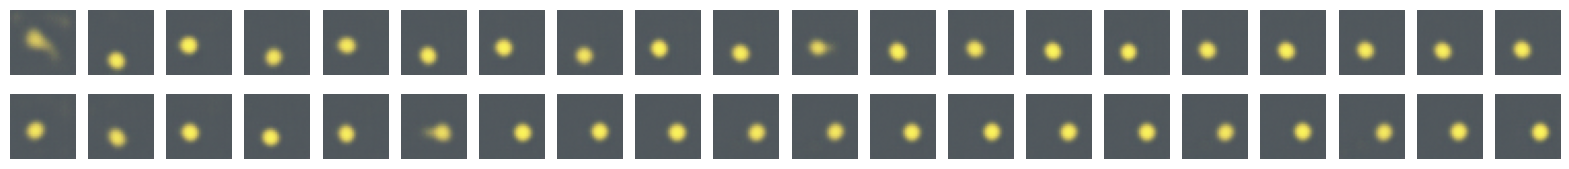

Epoch 1: 100%|██████████| 157/157 [00:36<00:00,  4.29batch/s, loss=150.988]


Recon MSE: 0.00197
Pred MSE: 0.01016


Epoch 2: 100%|██████████| 157/157 [00:36<00:00,  4.30batch/s, loss=141.236]


Recon MSE: 0.00170
Pred MSE: 0.01026


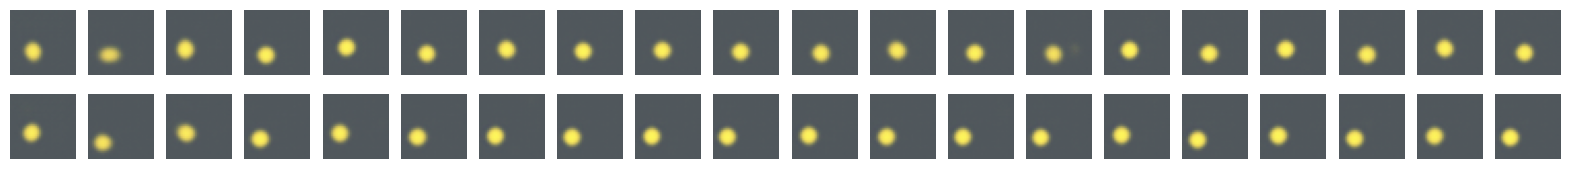

Epoch 3: 100%|██████████| 157/157 [00:36<00:00,  4.29batch/s, loss=137.070]


Recon MSE: 0.00167
Pred MSE: 0.01031


Epoch 4: 100%|██████████| 157/157 [00:37<00:00,  4.19batch/s, loss=124.358]


Recon MSE: 0.00138
Pred MSE: 0.01047


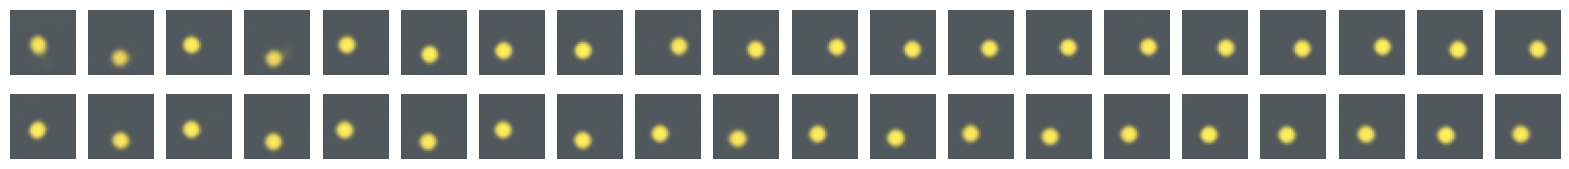

Epoch 5: 100%|██████████| 157/157 [00:38<00:00,  4.09batch/s, loss=112.337]


Recon MSE: 0.00119
Pred MSE: 0.01110


Epoch 6: 100%|██████████| 157/157 [00:38<00:00,  4.06batch/s, loss=108.465]


Recon MSE: 0.00107
Pred MSE: 0.01158


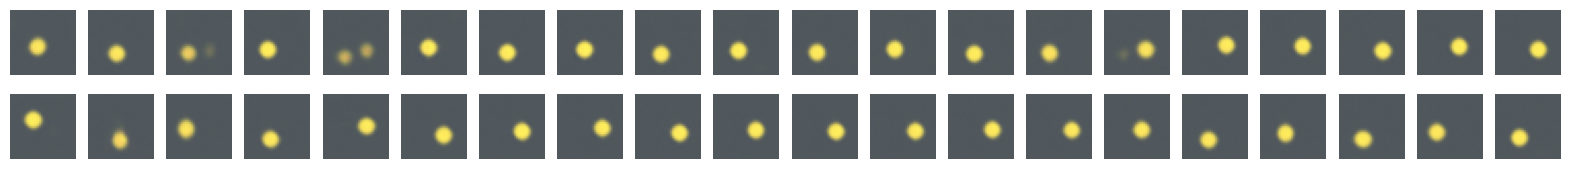

Epoch 7: 100%|██████████| 157/157 [00:38<00:00,  4.07batch/s, loss=98.544] 


Recon MSE: 0.00089
Pred MSE: 0.01185


Epoch 8: 100%|██████████| 157/157 [00:39<00:00,  4.02batch/s, loss=95.943] 


Recon MSE: 0.00083
Pred MSE: 0.01158


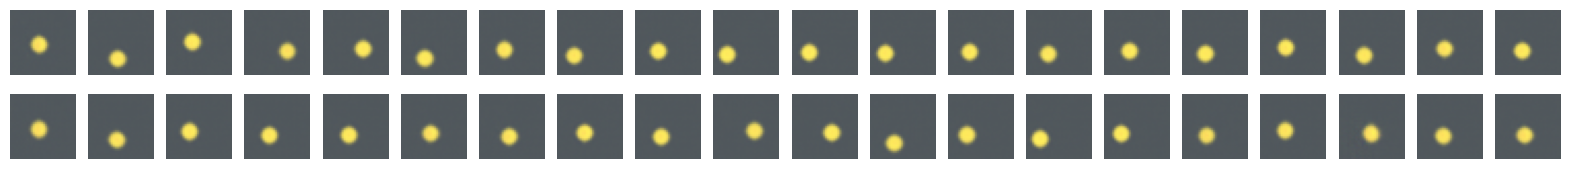

Epoch 9: 100%|██████████| 157/157 [00:38<00:00,  4.08batch/s, loss=94.278]


Recon MSE: 0.00072
Pred MSE: 0.01247


In [15]:
total_losses = []

test_mse_losses = [] 
predict_mse_losses = []

for epoch in range(epochs):
    model.train()
    with tqdm.tqdm(train_dataloader, unit="batch") as tepoch:
        for batch_idx, data in enumerate(tepoch):
            data = data[0].float().to(device)
            data = data + 0.5
            optimizer.zero_grad()
            total_loss, _ = model(data)

            # Keep in memory the losses
            total_losses.append(total_loss.item())

            total_loss.backward()
            optimizer.step()

            if batch_idx % 20 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(loss=f"{total_loss.item():.3f}")
    model.eval()
    with torch.inference_mode():
        mse_values = []
        predict_mse = []
        for sample in test_dataloader:
            B, T, C, H, W = sample[0].size()                    
            obs_var = sample[0].float().to(device)
            obs_var = obs_var + 0.5
            _, x_hat = model(obs_var)
            preds = model.predict_sequence(obs_var[:,:3], seq_len=(T-3))
            obs_var, x_hat = obs_var.cpu().numpy(), x_hat.cpu().reshape(B, T, C, H, W).numpy()
            preds = preds.cpu().reshape(B, (T-3), C, H, W).numpy()
            mse = np.mean(((x_hat - obs_var) ** 2))
            pred_mse = np.mean(((preds - obs_var[:,3:]) ** 2))  
            mse_values.append(mse)
            predict_mse.append(pred_mse)            
        mse_val = sum(mse_values) / len(mse_values)
        pred_val = sum(predict_mse) / len(predict_mse)
        test_mse_losses.append(mse_val.item())
        predict_mse_losses.append(pred_val.item())   
        print(f"Recon MSE: {mse_val:.5f}")
        print(f"Pred MSE: {pred_val:.5f}")                       

    if epoch%2==0:       
        with torch.inference_mode():
            s = model.sample(seq_len = 20, n_samples=2)
            s = s.cpu().numpy()     
        imshow_grid(s-0.5, n_row=2, n_col=20, fig_size_a=20, fig_size_b=2)              

In [15]:
PATH = 'vrnn_ball_elbo_2.pth'
#torch.save(model.state_dict(), PATH)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
test_mse_losses, predict_mse_losses

([0.0023508682497777045,
  0.0019715792877832428,
  0.0017032649629982188,
  0.0016718594561098143,
  0.0013760668953182176,
  0.0011929544707527384,
  0.0010657759994501248,
  0.0008932919372455217,
  0.0008259566893684678,
  0.0007239511542138644],
 [0.009807001915760338,
  0.010157677112147212,
  0.010258610243909061,
  0.010306498734280467,
  0.010473890928551555,
  0.011100120842456818,
  0.011583277606405318,
  0.011854222975671291,
  0.011582583887502551,
  0.012470660149119794])

Text(0, 0.5, 'Training Loss')

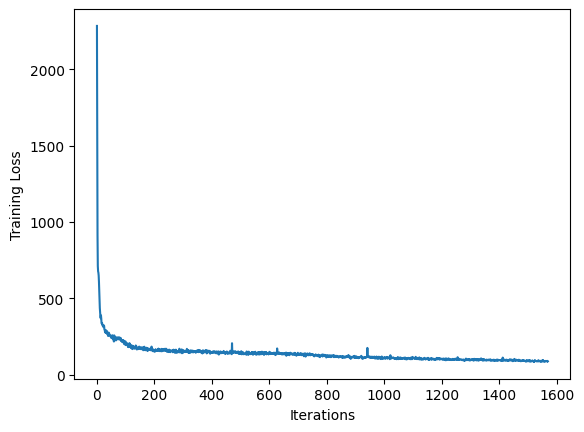

In [18]:
plt.plot(total_losses)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

Text(0, 0.5, 'MSE')

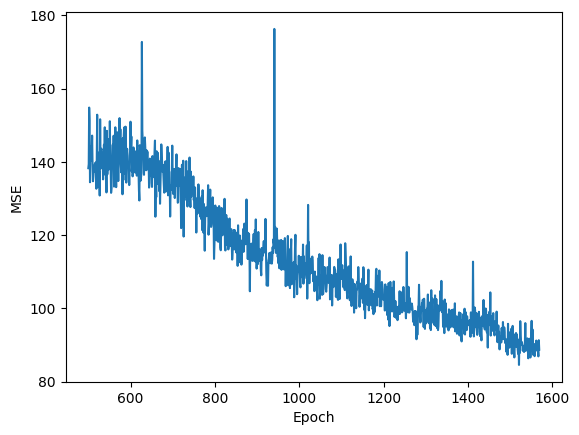

In [19]:
plt.plot(np.arange(500,len(total_losses)),total_losses[500:])
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

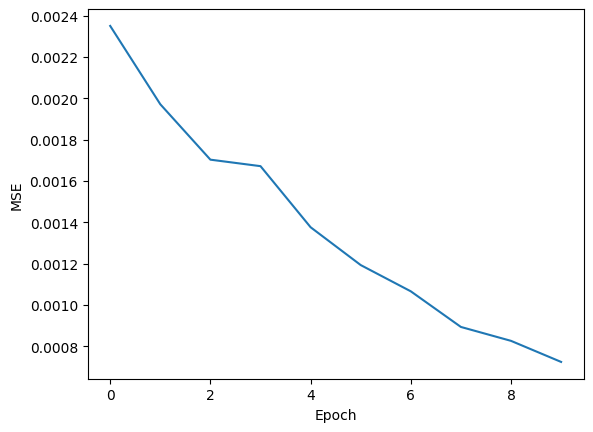

In [20]:
plt.plot(test_mse_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

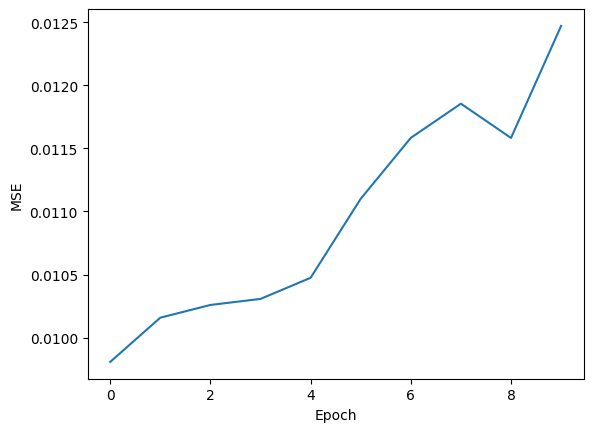

In [21]:
plt.plot(predict_mse_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [22]:
# Training time: 7min
print(f"Last ELBO Loss: {total_losses[-1]:.1f}")
print(f"Last Test MSE: {test_mse_losses[-1]:.6f}")
print(f"Last Pred MSE: {predict_mse_losses[-1]:.6f}")

Last ELBO Loss: 88.7
Last Test MSE: 0.000724
Last Pred MSE: 0.012471


In [23]:
print(f"Best ELBO Loss: {min(total_losses):.1f}")
print(f"Best Test MSE: {min(test_mse_losses):.6f}")
print(f"Best Pred MSE: {min(predict_mse_losses):.6f}")

Best ELBO Loss: 84.6
Best Test MSE: 0.000724
Best Pred MSE: 0.009807


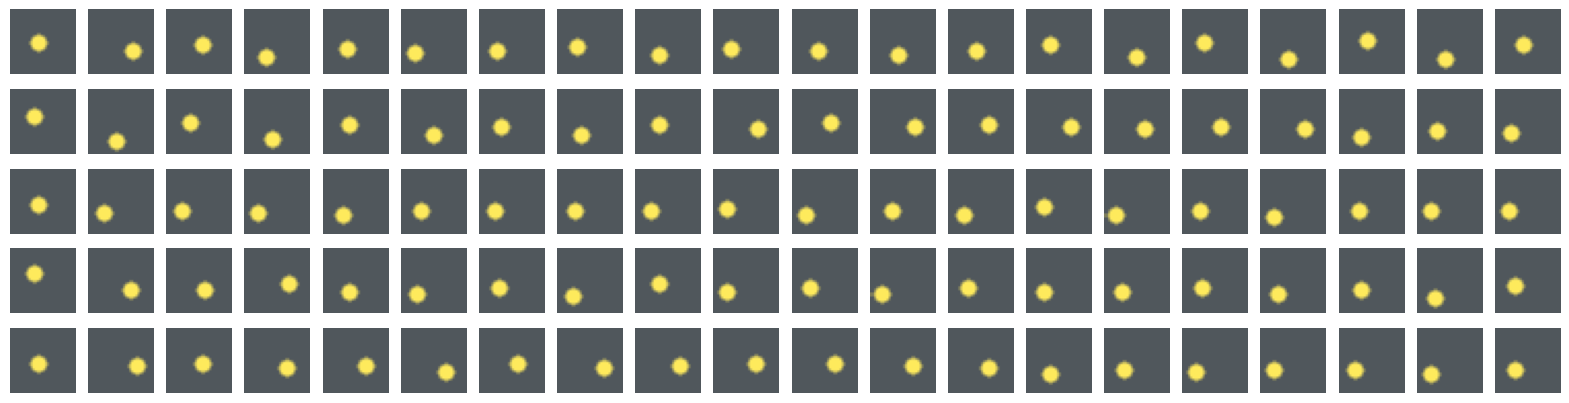

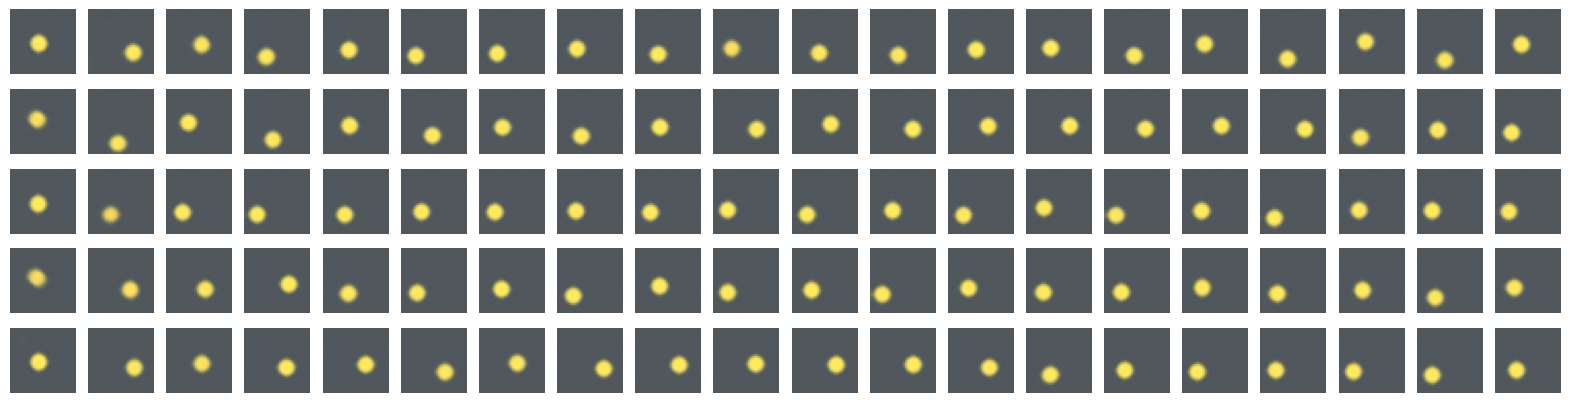

In [24]:
# Reconstructions

n_samples = 5
t = 20
recons = torch.zeros(n_samples, t, 3, 28, 28)
model.eval()

with torch.inference_mode():
    x = next(iter(test_dataloader))
    x = x[0].float().to(device)
    x = x + 0.5
    _,recon_x = model(x)
    x = x.cpu().numpy()
    recon_x = recon_x.cpu().numpy()

imshow_grid(x-0.5, n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)
imshow_grid(recon_x-0.5, n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)

In [25]:
# Final MSE per timestep
mse_T = np.mean(((x - recon_x) ** 2),axis=(0,2,3,4))
for i,element in enumerate(mse_T):
    print(f"t={i} MSE per pixel:{element:.6f}")

t=0 MSE per pixel:0.002349
t=1 MSE per pixel:0.001609
t=2 MSE per pixel:0.000747
t=3 MSE per pixel:0.000818
t=4 MSE per pixel:0.000659
t=5 MSE per pixel:0.000539
t=6 MSE per pixel:0.000584
t=7 MSE per pixel:0.000639
t=8 MSE per pixel:0.000677
t=9 MSE per pixel:0.000559
t=10 MSE per pixel:0.000773
t=11 MSE per pixel:0.000583
t=12 MSE per pixel:0.000635
t=13 MSE per pixel:0.000573
t=14 MSE per pixel:0.000726
t=15 MSE per pixel:0.000508
t=16 MSE per pixel:0.000613
t=17 MSE per pixel:0.000620
t=18 MSE per pixel:0.000566
t=19 MSE per pixel:0.000496


In [26]:
mse_T

array([0.00234858, 0.0016094 , 0.00074717, 0.00081846, 0.0006588 ,
       0.00053926, 0.00058389, 0.00063864, 0.00067746, 0.00055931,
       0.00077307, 0.00058304, 0.00063451, 0.00057294, 0.00072565,
       0.0005078 , 0.00061289, 0.00061951, 0.0005657 , 0.00049624],
      dtype=float32)

Text(0, 0.5, 'MSE per Pixel')

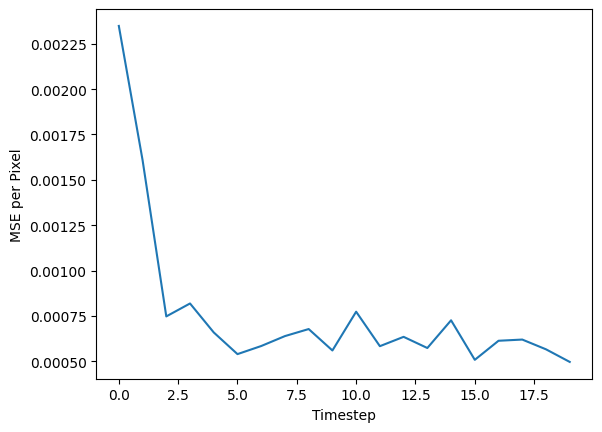

In [27]:
plt.plot(mse_T)
plt.xlabel('Timestep')
plt.ylabel('MSE per Pixel')

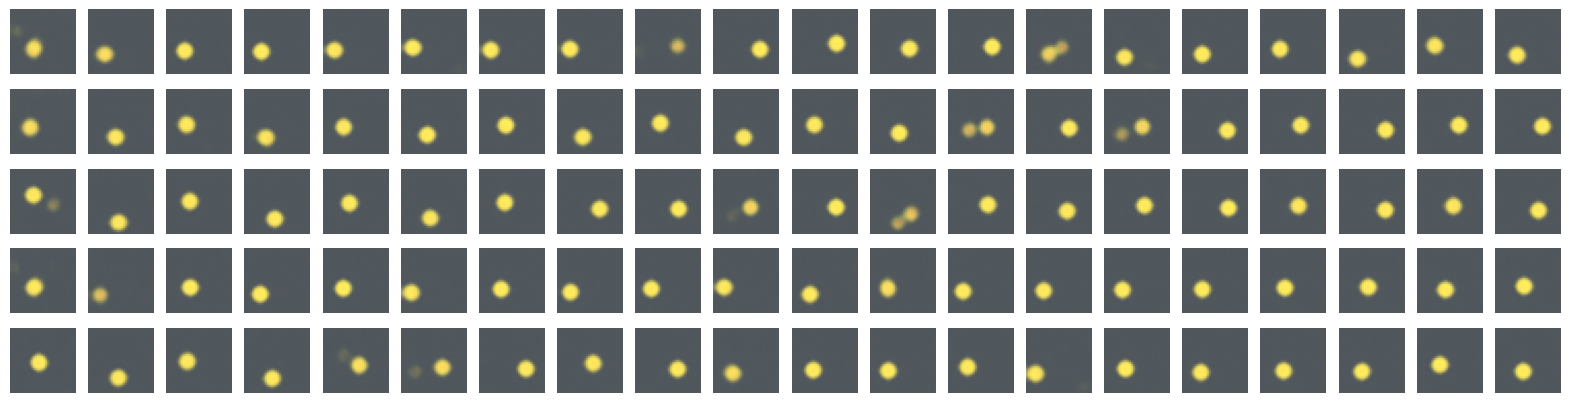

In [28]:
# Create samples

n_samples = 5
t = 20
model.eval()
with torch.inference_mode():
    s = model.sample(seq_len = t, n_samples=n_samples)
    s = s.cpu().numpy()
 
imshow_grid(s-0.5, n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)      

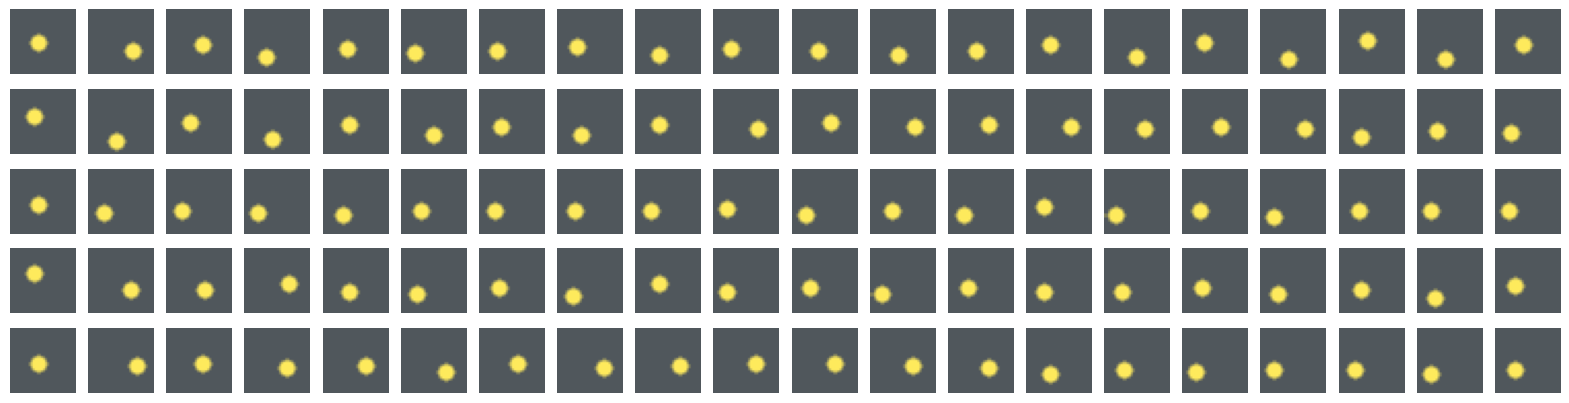

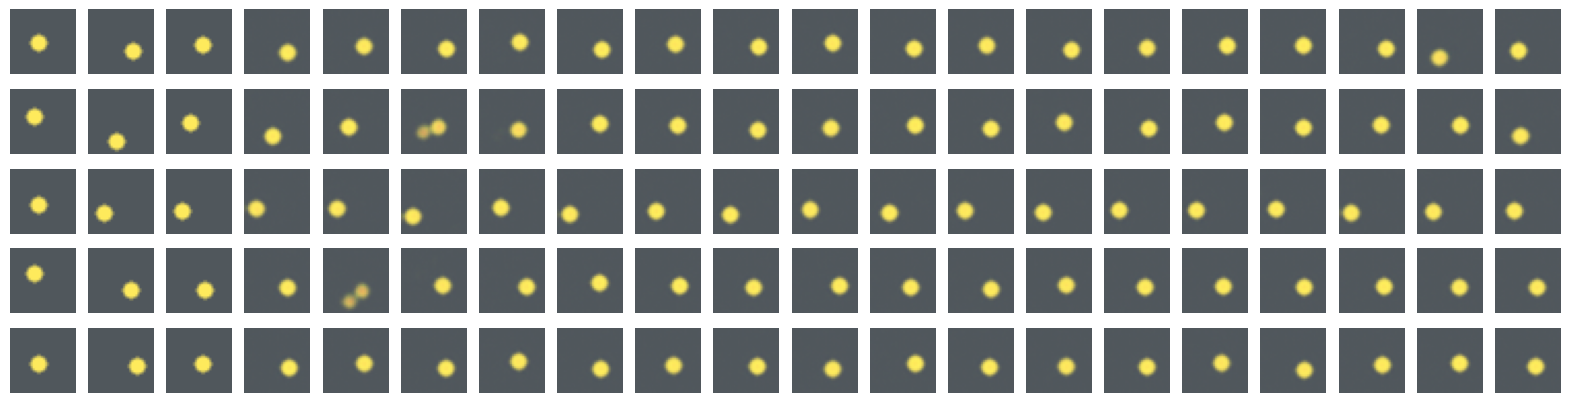

In [29]:
# Predictions

with torch.inference_mode():
    x = next(iter(test_dataloader))[0]
    x = (x.float().to(device))
    x = x + 0.5
    B = x.shape[0]
    preds = model.predict_sequence(x[:,:3], seq_len=17).cpu()
    x = x.cpu()
    preds = torch.cat((x[:,:3],preds),dim=1).cpu().numpy()
    x = x.numpy()

imshow_grid((x[:5]-0.5), n_row=5, n_col=20, fig_size_a=20, fig_size_b=5)
imshow_grid((preds[:5]-0.5), n_row=5, n_col=20, fig_size_a=20, fig_size_b=5)


In [30]:
with torch.inference_mode():
    predict_mse = []
    for sample in test_dataloader:
        mse_values = []
        sample = sample[0]
        B, T, C, H, W = sample.size()
        obs_var = sample.float().to(device)
        obs_var = obs_var + 0.5
        preds = model.predict_sequence(obs_var[:,:3], seq_len=T-3)
        obs_var, preds = obs_var.cpu().numpy(), preds.cpu().reshape(B, (T-3), C, H, W).numpy()
        mse = np.mean(((preds - obs_var[:,3:]) ** 2),axis=(0,2,3,4))
        mse_values.append(mse)
    mse_val = sum(mse_values) / len(mse_values)
    predict_mse.append(mse_val.tolist())

In [31]:
predict_mse[0]

[0.005442726891487837,
 0.007420139387249947,
 0.009917660616338253,
 0.011090265586972237,
 0.011581703089177608,
 0.013841537758708,
 0.014202198944985867,
 0.012129134498536587,
 0.011200226843357086,
 0.012423583306372166,
 0.012875725515186787,
 0.012894151732325554,
 0.01160520501434803,
 0.012049640528857708,
 0.01252617035061121,
 0.013620348647236824,
 0.013574967160820961]

([<matplotlib.axis.XTick at 0x7ad5c3c25a50>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16')])

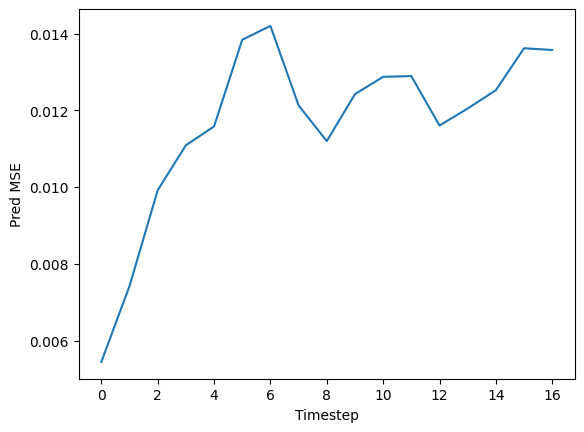

In [32]:
plt.plot(predict_mse[0])
plt.xlabel('Timestep')
plt.ylabel('Pred MSE')
plt.xticks(np.arange(0,18,2))

In [17]:
# Check ELBO,IWAE,FIVO values
# We expect FIVO<IWAE<ELBO

with torch.inference_mode():
    elbo_list = []
    iwae_list = []
    fivo_list = []
    for sample in tqdm.tqdm(test_dataloader):
        obs_var = sample[0].float().to(device)
        obs_var = obs_var + 0.5
        elbo,_ = model(obs_var)
        iwae, _ = model.iwae(obs_var, 10)
        fivo, _ = model.fivo(obs_var, 10)
        elbo = -elbo
        elbo_list.append(elbo)
        iwae_list.append(iwae)
        fivo_list.append(fivo)
    print(f"ELBO: {sum(elbo_list)/len(elbo_list):.2f}")
    print(f"IWAE: {sum(iwae_list)/len(iwae_list):.2f}")
    print(f"FIVO: {sum(fivo_list)/len(fivo_list):.2f}")

100%|██████████| 8/8 [00:11<00:00,  1.38s/it]

ELBO: -88
IWAE: -81
FIVO: -77


# IWAE

In [14]:
epochs = 10
particles = 10
learning_rate = 1e-3
model = VRNN(h_dim=64,z_dim=128)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch 0: 100%|██████████| 157/157 [01:35<00:00,  1.64batch/s, loss=141.4082]


Recon MSE: 0.00210
Pred MSE: 0.01031


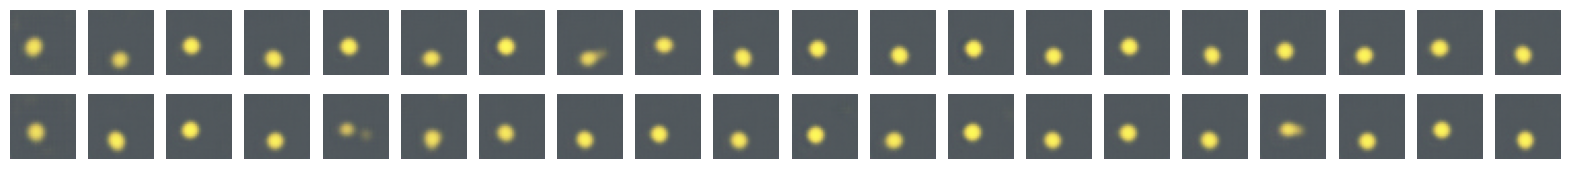

Epoch 1: 100%|██████████| 157/157 [01:36<00:00,  1.63batch/s, loss=130.7246]


Recon MSE: 0.00181
Pred MSE: 0.01121


Epoch 2: 100%|██████████| 157/157 [01:35<00:00,  1.64batch/s, loss=118.3530]


Recon MSE: 0.00178
Pred MSE: 0.01030


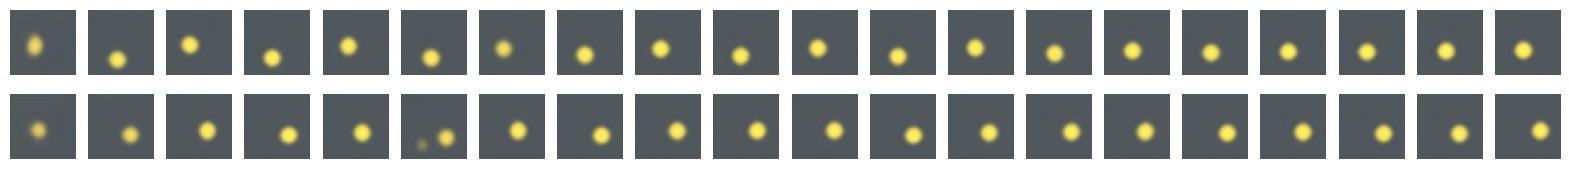

Epoch 3: 100%|██████████| 157/157 [01:35<00:00,  1.65batch/s, loss=109.9904]


Recon MSE: 0.00177
Pred MSE: 0.01120


Epoch 4: 100%|██████████| 157/157 [01:35<00:00,  1.65batch/s, loss=109.8223]


Recon MSE: 0.00191
Pred MSE: 0.01034


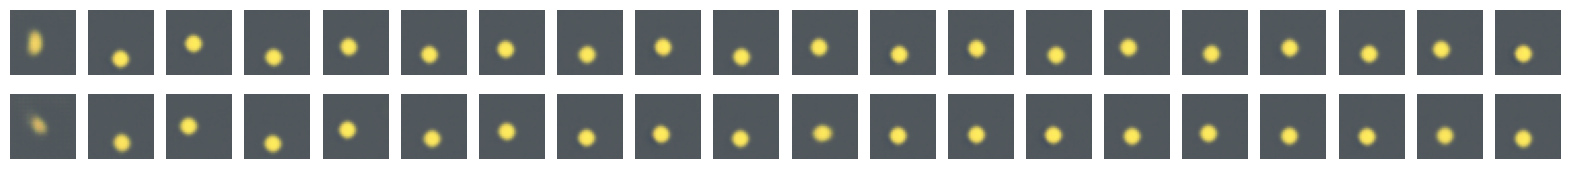

Epoch 5: 100%|██████████| 157/157 [01:34<00:00,  1.65batch/s, loss=107.6401]


Recon MSE: 0.00156
Pred MSE: 0.01085


Epoch 6: 100%|██████████| 157/157 [01:35<00:00,  1.65batch/s, loss=108.5882]


Recon MSE: 0.00170
Pred MSE: 0.01104


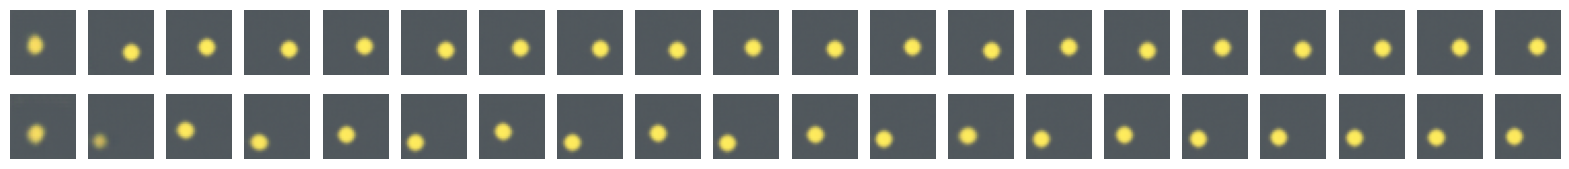

Epoch 7: 100%|██████████| 157/157 [01:35<00:00,  1.65batch/s, loss=106.5599]


Recon MSE: 0.00167
Pred MSE: 0.01105


Epoch 8: 100%|██████████| 157/157 [01:34<00:00,  1.65batch/s, loss=102.0286]


Recon MSE: 0.00162
Pred MSE: 0.01133


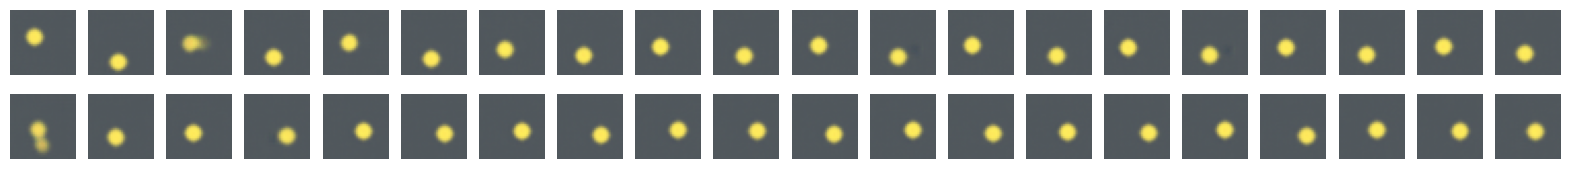

Epoch 9: 100%|██████████| 157/157 [01:35<00:00,  1.65batch/s, loss=95.9013] 


Recon MSE: 0.00131
Pred MSE: 0.01123


In [35]:
total_losses_iwae = []
mse_losses_iwae = []
predict_mse_iwae = []

for epoch in range(epochs):
    model.train()
    with tqdm.tqdm(train_dataloader, unit="batch") as tepoch:
        for batch_idx, data in enumerate(tepoch):
            data = data[0].float().to(device)
            data = data + 0.5
            optimizer.zero_grad()
            total_loss, log_probs = model.iwae(data, particles)
            total_loss = - total_loss

            # Keep in memory the losses
            total_losses_iwae.append(total_loss.item())

            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            total_loss.backward()
            optimizer.step()

            if batch_idx % 20 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(loss=f"{total_loss.item():.4f}")
    model.eval()
    with torch.inference_mode():
        mse_values = []
        predict_mse = []
        for sample in test_dataloader:
            B, T, C, H, W = sample[0].size()                    
            obs_var = sample[0].float().to(device)
            obs_var = obs_var + 0.5
            _, x_hat = model(obs_var)
            preds = model.predict_sequence(obs_var[:,:3], seq_len=(T-3))
            obs_var, x_hat = obs_var.cpu().numpy(), x_hat.cpu().reshape(B, T, C, H, W).numpy()
            preds = preds.cpu().reshape(B, (T-3), C, H, W).numpy()
            mse = np.mean(((x_hat - obs_var) ** 2))
            pred_mse = np.mean(((preds - obs_var[:,3:]) ** 2))  
            mse_values.append(mse)
            predict_mse.append(pred_mse)            
        mse_val = sum(mse_values) / len(mse_values)
        pred_val = sum(predict_mse) / len(predict_mse)
        mse_losses_iwae.append(mse_val.item())
        predict_mse_iwae.append(pred_val.item())   
        print(f"Recon MSE: {mse_val:.5f}")
        print(f"Pred MSE: {pred_val:.5f}")                       

    if epoch%2==0:       
        with torch.inference_mode():
            s = model.sample(seq_len = 20, n_samples=2)
            s = s.cpu().numpy()     
        imshow_grid(s-0.5, n_row=2, n_col=20, fig_size_a=20, fig_size_b=2)

In [16]:
PATH = 'vrnn_ball_iwae_2.pth'
#torch.save(model.state_dict(), PATH)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [37]:
mse_losses_iwae, predict_mse_iwae

([0.002096926880767569,
  0.0018148187373299152,
  0.001780068560037762,
  0.0017718344897730276,
  0.0019113302405457944,
  0.0015574829594697803,
  0.0016968902491498739,
  0.0016654112696414813,
  0.0016232553170993924,
  0.0013084261736366898],
 [0.010307610733434558,
  0.011209872900508344,
  0.010299792280420661,
  0.011197721818462014,
  0.010336422245018184,
  0.01084766793064773,
  0.011041289893910289,
  0.011051406152546406,
  0.01132652082014829,
  0.011228650459088385])

Text(0, 0.5, 'Training Loss')

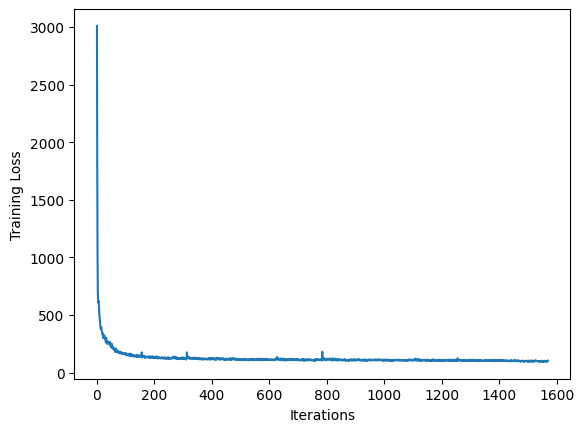

In [38]:
plt.plot(total_losses_iwae)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

Text(0, 0.5, 'MSE')

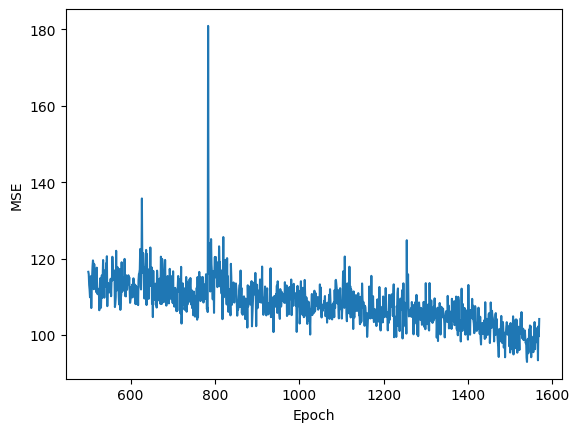

In [39]:
plt.plot(np.arange(500,len(total_losses_iwae)),total_losses_iwae[500:])
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

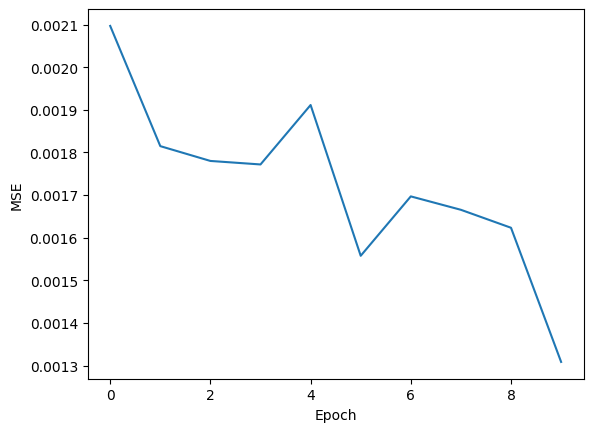

In [40]:
plt.plot(mse_losses_iwae)
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

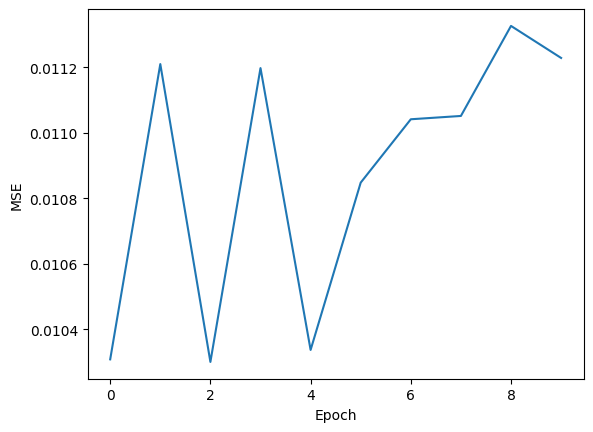

In [41]:
plt.plot(predict_mse_iwae)
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [42]:
# Training time: 16min
print(f"Last IWAE Loss: {total_losses_iwae[-1]:.1f}")
print(f"Last Test MSE: {mse_losses_iwae[-1]:.6f}")
print(f"Last Pred MSE: {predict_mse_iwae[-1]:.6f}")

Last IWAE Loss: 104.2
Last Test MSE: 0.001308
Last Pred MSE: 0.011229


In [43]:
print(f"Best IWAE Loss: {min(total_losses_iwae):.1f}")
print(f"Best Test MSE: {min(mse_losses_iwae):.6f}")
print(f"Best Pred MSE: {min(predict_mse_iwae):.6f}")

Best IWAE Loss: 93.0
Best Test MSE: 0.001308
Best Pred MSE: 0.010300


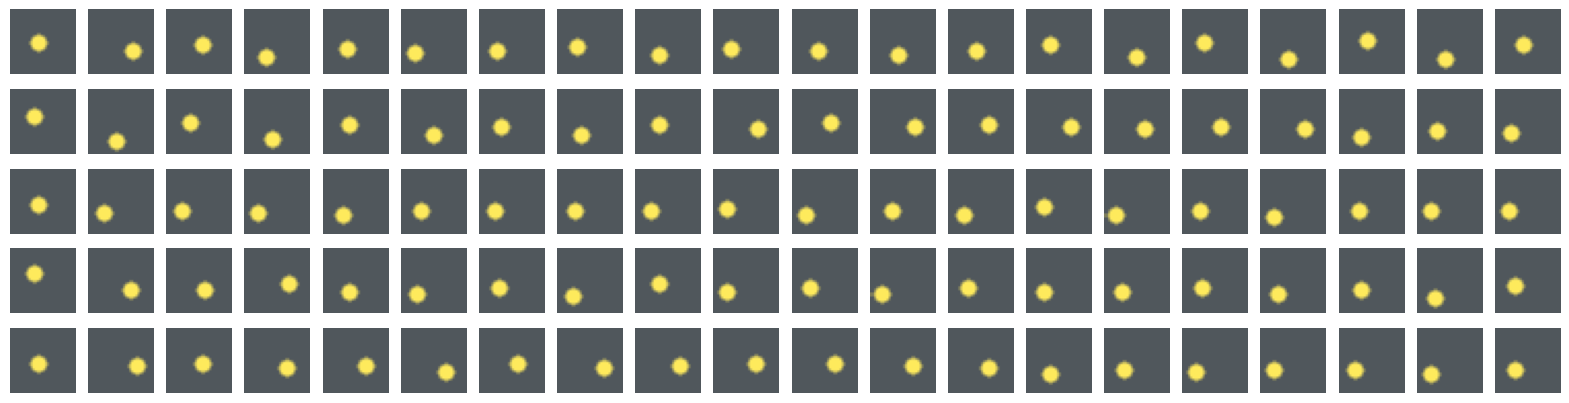

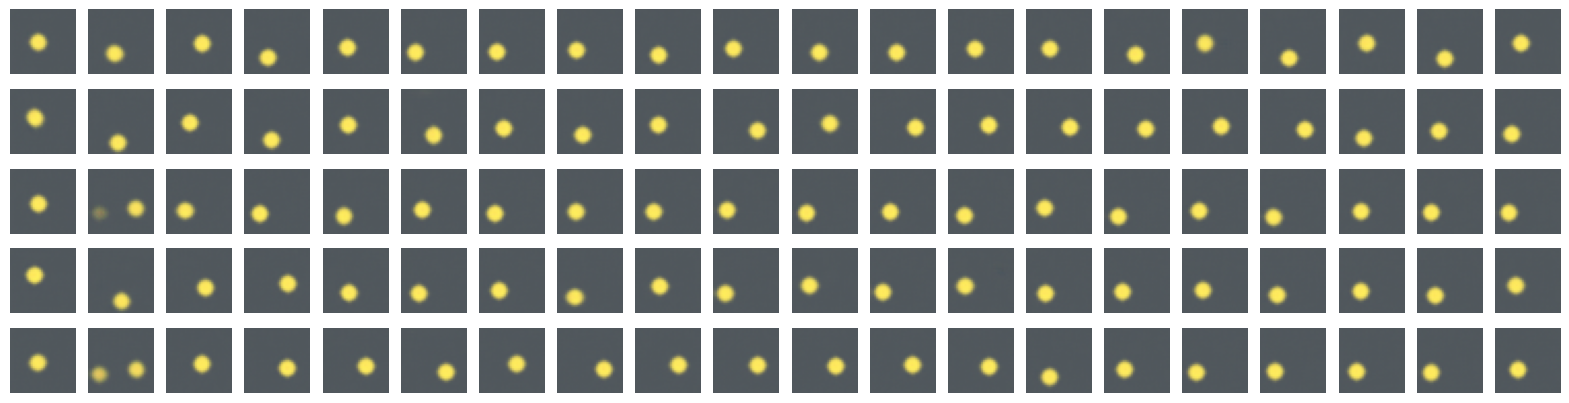

In [44]:
# Reconstructions

n_samples = 5
t = 20
recons = torch.zeros(n_samples, t, 3, 28, 28)
model.eval()

with torch.inference_mode():
    x = next(iter(test_dataloader))
    x = x[0].float().to(device)
    x = x + 0.5
    _,recon_x = model(x)
    x = x.cpu().numpy()
    recon_x = recon_x.cpu().numpy()

imshow_grid(x-0.5, n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)
imshow_grid(recon_x-0.5, n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)

In [45]:
# Final MSE per timestep
mse_T = np.mean(((x - recon_x) ** 2),axis=(0,2,3,4))
for i,element in enumerate(mse_T):
    print(f"t={i} MSE per pixel:{element:.6f}")

t=0 MSE per pixel:0.001655
t=1 MSE per pixel:0.003190
t=2 MSE per pixel:0.001397
t=3 MSE per pixel:0.000953
t=4 MSE per pixel:0.001019
t=5 MSE per pixel:0.001117
t=6 MSE per pixel:0.001059
t=7 MSE per pixel:0.000880
t=8 MSE per pixel:0.001740
t=9 MSE per pixel:0.001717
t=10 MSE per pixel:0.001303
t=11 MSE per pixel:0.001223
t=12 MSE per pixel:0.001268
t=13 MSE per pixel:0.001292
t=14 MSE per pixel:0.000845
t=15 MSE per pixel:0.001404
t=16 MSE per pixel:0.001307
t=17 MSE per pixel:0.001156
t=18 MSE per pixel:0.001619
t=19 MSE per pixel:0.001104


In [46]:
mse_T

array([0.00165519, 0.00319049, 0.00139666, 0.00095295, 0.00101887,
       0.00111733, 0.00105921, 0.00087992, 0.00174008, 0.0017167 ,
       0.00130288, 0.00122268, 0.00126793, 0.00129227, 0.00084511,
       0.00140429, 0.00130671, 0.00115605, 0.00161885, 0.00110353],
      dtype=float32)

Text(0, 0.5, 'MSE per Pixel')

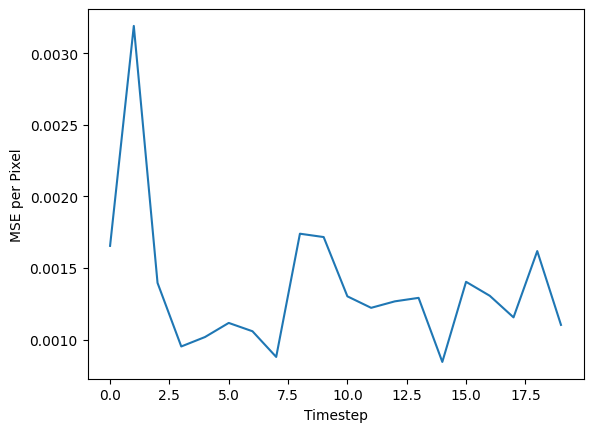

In [47]:
plt.plot(mse_T)
plt.xlabel('Timestep')
plt.ylabel('MSE per Pixel')

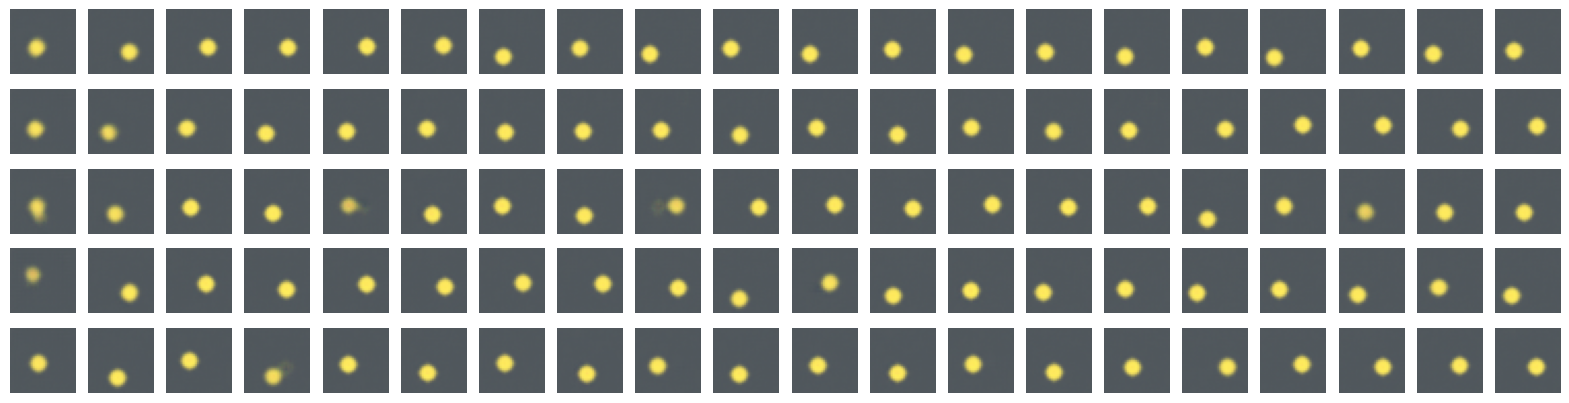

In [48]:
# Create samples

n_samples = 5
t = 20
model.eval()
with torch.inference_mode():
    s = model.sample(seq_len = t, n_samples=n_samples)
    s = s.cpu().numpy()
 
imshow_grid(s-0.5, n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)      

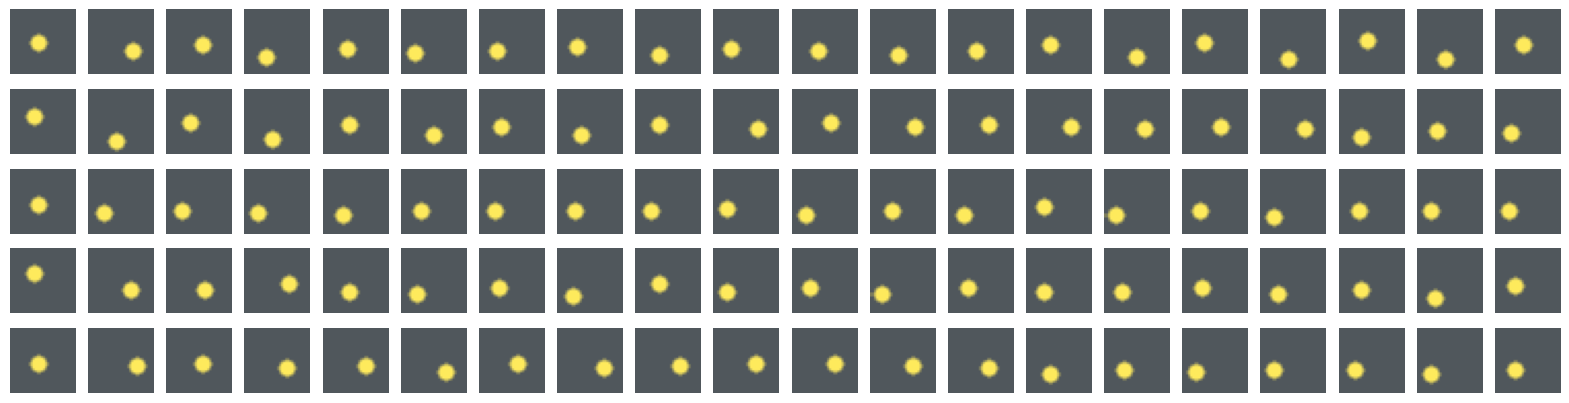

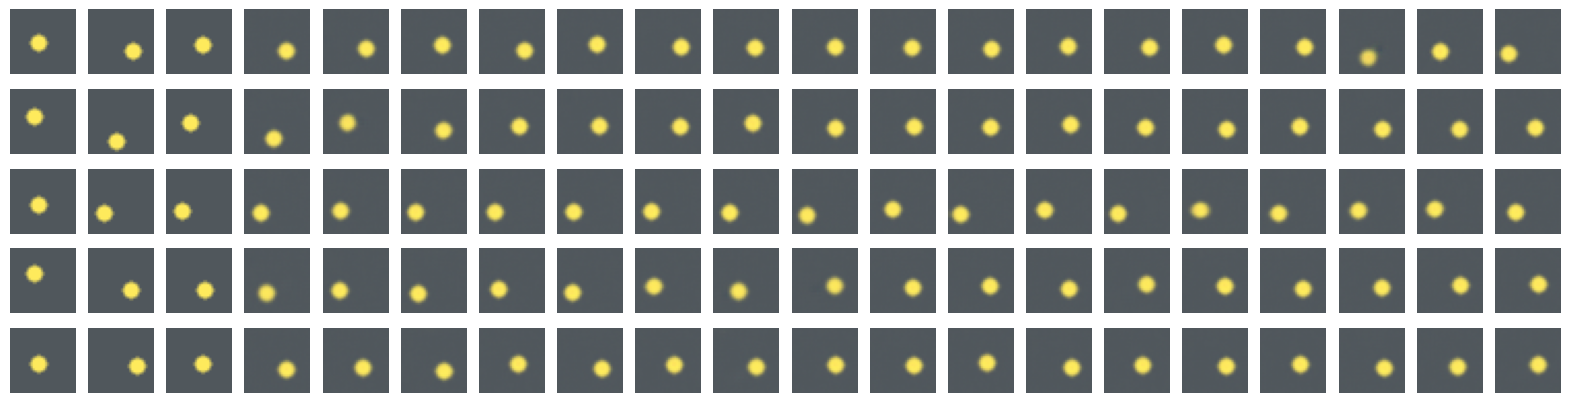

In [49]:
# Predictions

with torch.inference_mode():
    x = next(iter(test_dataloader))[0]
    x = (x.float().to(device))
    x = x + 0.5
    B = x.shape[0]
    preds = model.predict_sequence(x[:,:3], seq_len=17).cpu()
    x = x.cpu()
    preds = torch.cat((x[:,:3],preds),dim=1).cpu().numpy()
    x = x.numpy()

imshow_grid((x[:5]-0.5), n_row=5, n_col=20, fig_size_a=20, fig_size_b=5)
imshow_grid((preds[:5]-0.5), n_row=5, n_col=20, fig_size_a=20, fig_size_b=5)


In [50]:
with torch.inference_mode():
    predict_mse = []
    for sample in test_dataloader:
        mse_values = []
        sample = sample[0]
        B, T, C, H, W = sample.size()
        obs_var = sample.float().to(device)
        obs_var = obs_var + 0.5
        preds = model.predict_sequence(obs_var[:,:3], seq_len=T-3)
        obs_var, preds = obs_var.cpu().numpy(), preds.cpu().reshape(B, (T-3), C, H, W).numpy()
        mse = np.mean(((preds - obs_var[:,3:]) ** 2),axis=(0,2,3,4))
        mse_values.append(mse)
    mse_val = sum(mse_values) / len(mse_values)
    predict_mse.append(mse_val.tolist())

In [51]:
predict_mse[0]

[0.004630283918231726,
 0.0072969007305800915,
 0.010184068232774734,
 0.010959001258015633,
 0.010054091922938824,
 0.010418321006000042,
 0.010462818667292595,
 0.010699384845793247,
 0.011122496798634529,
 0.010671471245586872,
 0.012562219053506851,
 0.011595458723604679,
 0.012861309573054314,
 0.012590606696903706,
 0.013567869551479816,
 0.012885725125670433,
 0.014488530345261097]

([<matplotlib.axis.XTick at 0x7ad5ba8cee30>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16')])

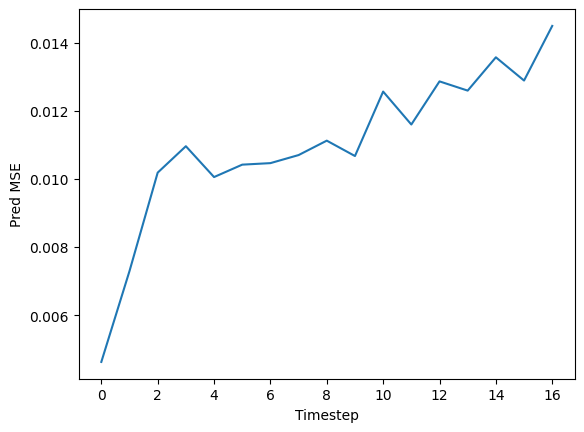

In [52]:
plt.plot(predict_mse[0])
plt.xlabel('Timestep')
plt.ylabel('Pred MSE')
plt.xticks(np.arange(0,18,2))

In [53]:
# Check ELBO,IWAE,FIVO values
# We expect FIVO<IWAE<ELBO

with torch.inference_mode():
    elbo_list = []
    iwae_list = []
    fivo_list = []
    for sample in tqdm.tqdm(train_dataloader):
        obs_var = sample[0].float().to(device)
        obs_var = obs_var + 0.5
        elbo, _ = model(obs_var)
        iwae, _ = model.iwae(obs_var, 10)
        fivo, _ = model.fivo(obs_var, 10)
        iwae = -iwae
        fivo = -fivo
        elbo_list.append(elbo)
        iwae_list.append(iwae)
        fivo_list.append(fivo)
    print(f"ELBO: {sum(elbo_list)/len(elbo_list):.0f}")
    print(f"IWAE: {sum(iwae_list)/len(iwae_list):.0f}")
    print(f"FIVO: {sum(fivo_list)/len(fivo_list):.0f}")

100%|██████████| 157/157 [01:13<00:00,  2.13it/s]

ELBO: 133
IWAE: 106
FIVO: 92


# FIVO

In [14]:
epochs = 10
particles = 10
learning_rate = 1e-3
model = VRNN(h_dim=64,z_dim=128)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch 0: 100%|██████████| 157/157 [01:42<00:00,  1.54batch/s, loss=97.8773] 


Recon MSE: 0.00334
Pred MSE: 0.01123


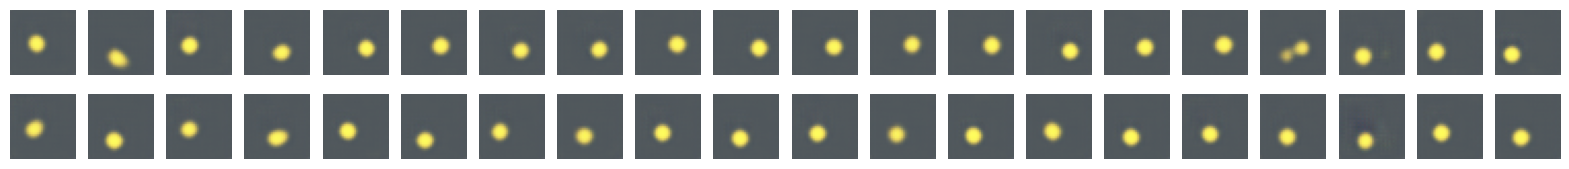

Epoch 1: 100%|██████████| 157/157 [01:40<00:00,  1.56batch/s, loss=81.2738]


Recon MSE: 0.00302
Pred MSE: 0.01217


Epoch 2: 100%|██████████| 157/157 [01:40<00:00,  1.55batch/s, loss=77.8780]


Recon MSE: 0.00320
Pred MSE: 0.01230


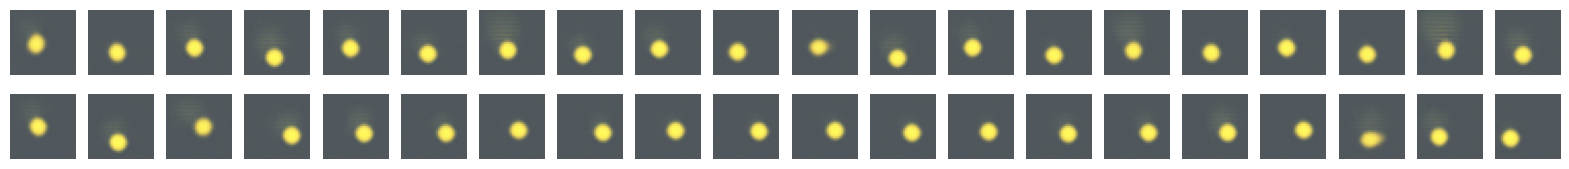

Epoch 3: 100%|██████████| 157/157 [01:40<00:00,  1.56batch/s, loss=74.3349]


Recon MSE: 0.00323
Pred MSE: 0.01196


Epoch 4: 100%|██████████| 157/157 [01:40<00:00,  1.56batch/s, loss=77.2907]


Recon MSE: 0.00318
Pred MSE: 0.01160


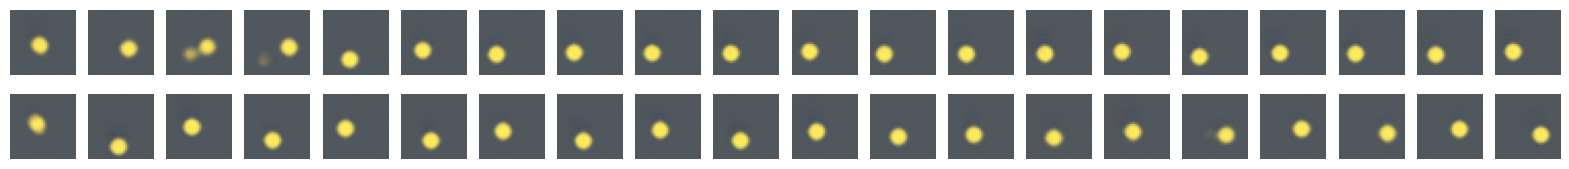

Epoch 5: 100%|██████████| 157/157 [01:41<00:00,  1.55batch/s, loss=73.0776]


Recon MSE: 0.00312
Pred MSE: 0.01166


Epoch 6: 100%|██████████| 157/157 [01:40<00:00,  1.56batch/s, loss=73.0915]


Recon MSE: 0.00331
Pred MSE: 0.01211


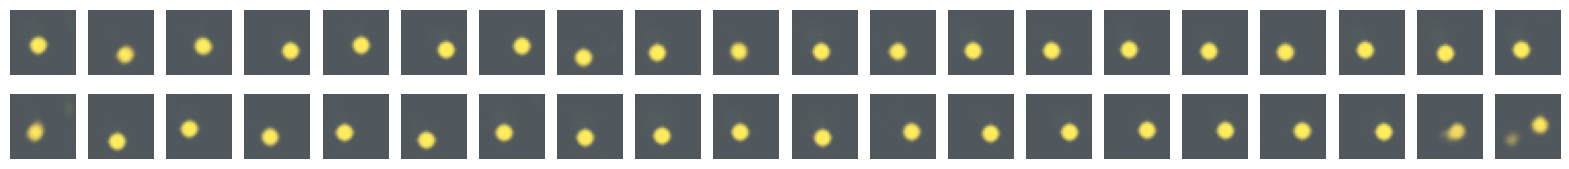

Epoch 7: 100%|██████████| 157/157 [01:40<00:00,  1.56batch/s, loss=71.0004]


Recon MSE: 0.00300
Pred MSE: 0.01219


Epoch 8: 100%|██████████| 157/157 [01:41<00:00,  1.55batch/s, loss=72.4600]


Recon MSE: 0.00319
Pred MSE: 0.01180


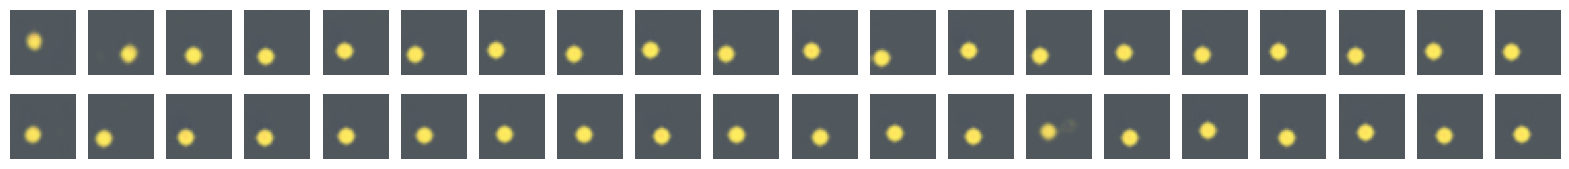

Epoch 9: 100%|██████████| 157/157 [01:41<00:00,  1.55batch/s, loss=71.5747]


Recon MSE: 0.00287
Pred MSE: 0.01209


In [15]:
total_losses_fivo = []
mse_losses_fivo = []
predict_mse_fivo = []

for epoch in range(epochs):
    model.train()
    with tqdm.tqdm(train_dataloader, unit="batch") as tepoch:
        for batch_idx, data in enumerate(tepoch):
            data = data[0].float().to(device)
            data = data + 0.5
            optimizer.zero_grad()
            total_loss, log_probs = model.fivo(data, particles)
            total_loss = - total_loss
        
            # Keep in memory the losses
            total_losses_fivo.append(total_loss.item())
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            total_loss.backward()
            optimizer.step()
            if batch_idx % 20 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(loss=f"{total_loss.item():.4f}")
                
    model.eval()
    with torch.inference_mode():
        mse_values = []
        predict_mse = []
        for sample in test_dataloader:
            B, T, C, H, W = sample[0].size()                    
            obs_var = sample[0].float().to(device)
            obs_var = obs_var + 0.5
            _, x_hat = model(obs_var)
            preds = model.predict_sequence(obs_var[:,:3], seq_len=(T-3))
            obs_var, x_hat = obs_var.cpu().numpy(), x_hat.cpu().reshape(B, T, C, H, W).numpy()
            preds = preds.cpu().reshape(B, (T-3), C, H, W).numpy()
            mse = np.mean(((x_hat - obs_var) ** 2))
            pred_mse = np.mean(((preds - obs_var[:,3:]) ** 2))  
            mse_values.append(mse)
            predict_mse.append(pred_mse)            
        mse_val = sum(mse_values) / len(mse_values)
        pred_val = sum(predict_mse) / len(predict_mse)
        mse_losses_fivo.append(mse_val.item())
        predict_mse_fivo.append(pred_val.item())   
        print(f"Recon MSE: {mse_val:.5f}")
        print(f"Pred MSE: {pred_val:.5f}")                       

    if epoch%2==0:       
        with torch.inference_mode():
            s = model.sample(seq_len = 20, n_samples=2)
            s = s.cpu().numpy()     
        imshow_grid(s-0.5, n_row=2, n_col=20, fig_size_a=20, fig_size_b=2)

In [28]:
PATH = 'vrnn_ball_fivo_2.pth'
torch.save(model.state_dict(), PATH)
# model.load_state_dict(torch.load(PATH))

In [16]:
mse_losses_fivo, predict_mse_fivo

([0.0033358519431203604,
  0.0030187306983862072,
  0.0032005872344598174,
  0.0032333405106328428,
  0.0031782771984580904,
  0.0031196018389891833,
  0.0033060969144571573,
  0.003003205143613741,
  0.0031878780282568187,
  0.002869451680453494],
 [0.011229021241888404,
  0.012169545516371727,
  0.012301752460189164,
  0.011962863500230014,
  0.011604210711084306,
  0.011661062249913812,
  0.012107523740269244,
  0.012187029351480305,
  0.011795951751992106,
  0.012094971141777933])

Text(0, 0.5, 'Training Loss')

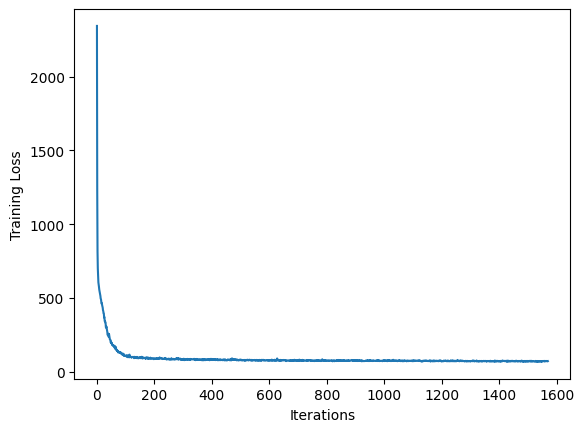

In [17]:
plt.plot(total_losses_fivo)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

Text(0, 0.5, 'MSE')

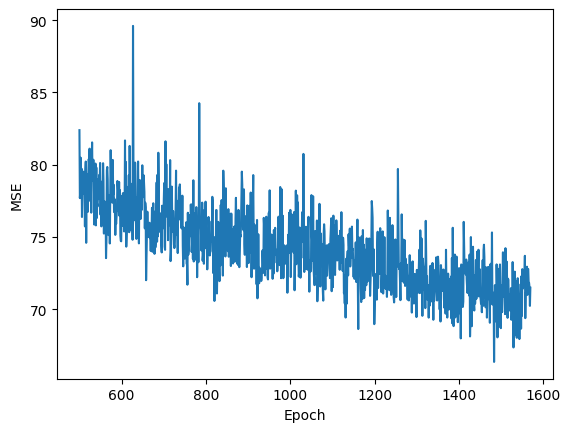

In [18]:
plt.plot(np.arange(500,len(total_losses_fivo)),total_losses_fivo[500:])
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

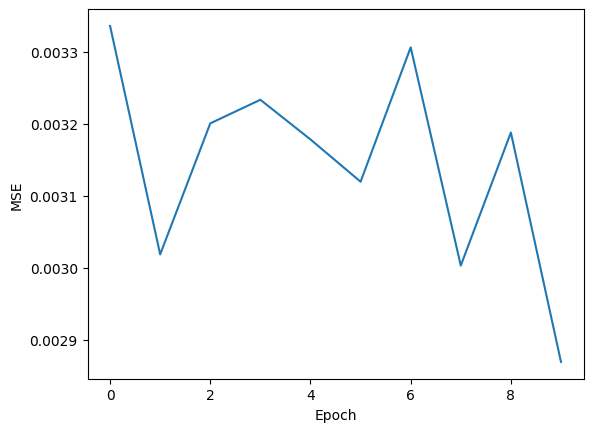

In [19]:
plt.plot(mse_losses_fivo)
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

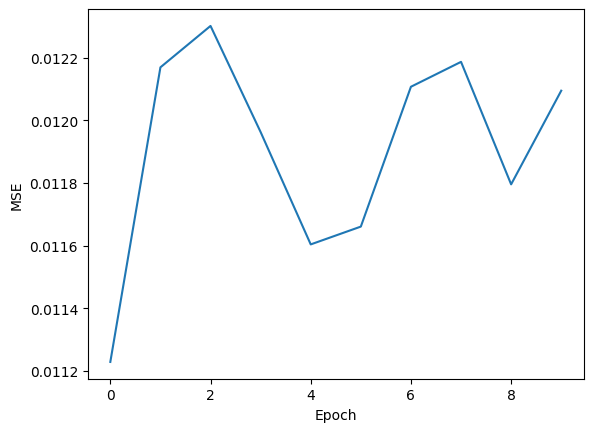

In [20]:
plt.plot(predict_mse_fivo)
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [21]:
# Training time: 17min
print(f"Last FIVO Loss: {total_losses_fivo[-1]:.1f}")
print(f"Last Test MSE: {mse_losses_fivo[-1]:.6f}")
print(f"Last Pred MSE: {predict_mse_fivo[-1]:.6f}")

Last FIVO Loss: 71.5
Last Test MSE: 0.002869
Last Pred MSE: 0.012095


In [22]:
print(f"Best FIVO Loss: {min(total_losses_fivo):.1f}")
print(f"Best Test MSE: {min(mse_losses_fivo):.6f}")
print(f"Best Pred MSE: {min(predict_mse_fivo):.6f}")

Best FIVO Loss: 66.4
Best Test MSE: 0.002869
Best Pred MSE: 0.011229


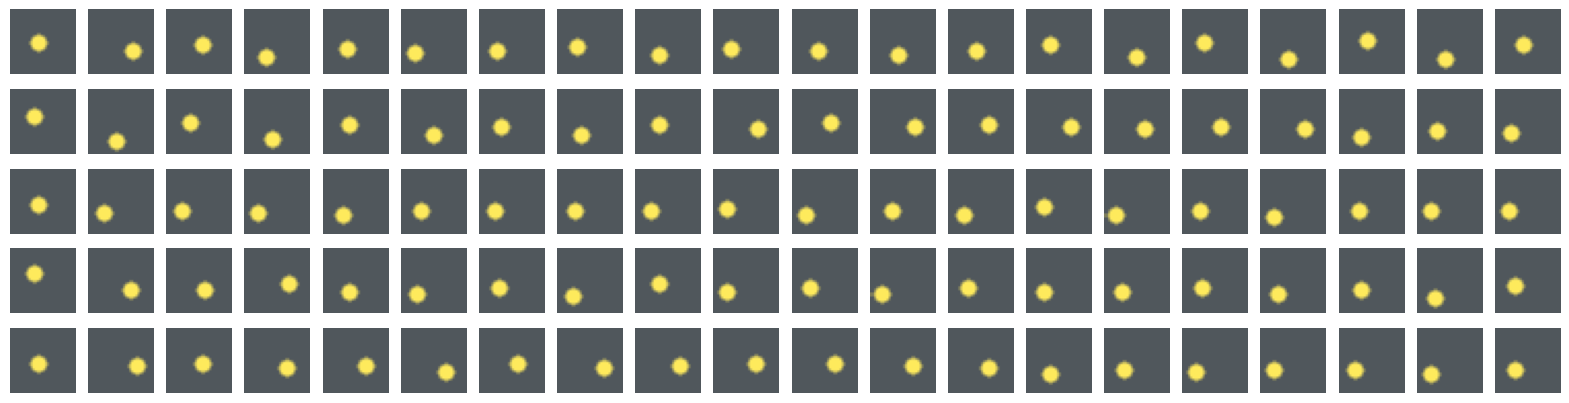

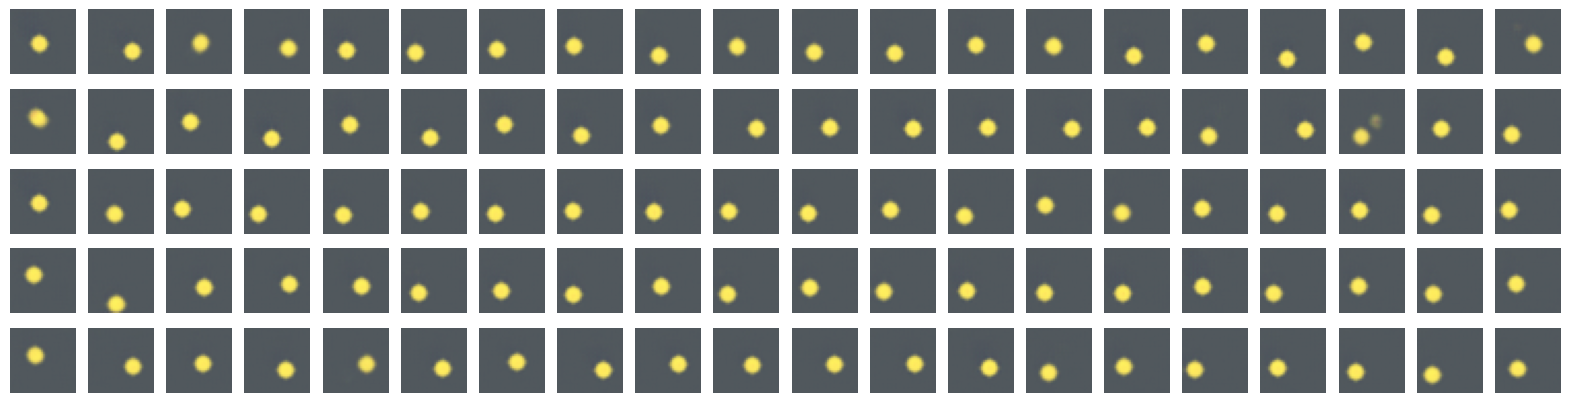

In [23]:
# Reconstructions

n_samples = 5
t = 20
recons = torch.zeros(n_samples, t, 3, 28, 28)
model.eval()

with torch.inference_mode():
    x = next(iter(test_dataloader))
    x = x[0].float().to(device)
    x = x + 0.5
    _,recon_x = model(x)
    x = x.cpu().numpy()
    recon_x = recon_x.cpu().numpy()

imshow_grid(x-0.5, n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)
imshow_grid(recon_x-0.5, n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)

In [24]:
# Final MSE per timestep
mse_T = np.mean(((x - recon_x) ** 2),axis=(0,2,3,4))
for i,element in enumerate(mse_T):
    print(f"t={i} MSE per pixel:{element:.6f}")

t=0 MSE per pixel:0.003867
t=1 MSE per pixel:0.004652
t=2 MSE per pixel:0.002977
t=3 MSE per pixel:0.003091
t=4 MSE per pixel:0.003784
t=5 MSE per pixel:0.002886
t=6 MSE per pixel:0.002315
t=7 MSE per pixel:0.003274
t=8 MSE per pixel:0.003060
t=9 MSE per pixel:0.003351
t=10 MSE per pixel:0.002815
t=11 MSE per pixel:0.003139
t=12 MSE per pixel:0.004196
t=13 MSE per pixel:0.002475
t=14 MSE per pixel:0.003156
t=15 MSE per pixel:0.002310
t=16 MSE per pixel:0.002802
t=17 MSE per pixel:0.002320
t=18 MSE per pixel:0.003124
t=19 MSE per pixel:0.003033


In [25]:
mse_T

array([0.003867  , 0.00465199, 0.00297731, 0.00309102, 0.00378352,
       0.00288574, 0.00231547, 0.00327399, 0.00306029, 0.00335143,
       0.00281465, 0.00313913, 0.00419602, 0.00247461, 0.00315623,
       0.00231029, 0.00280159, 0.00232037, 0.00312394, 0.00303316],
      dtype=float32)

Text(0, 0.5, 'MSE per Pixel')

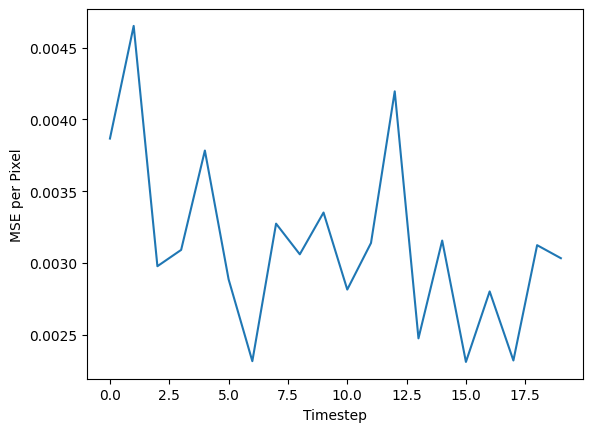

In [29]:
plt.plot(mse_T)
plt.xlabel('Timestep')
plt.ylabel('MSE per Pixel')

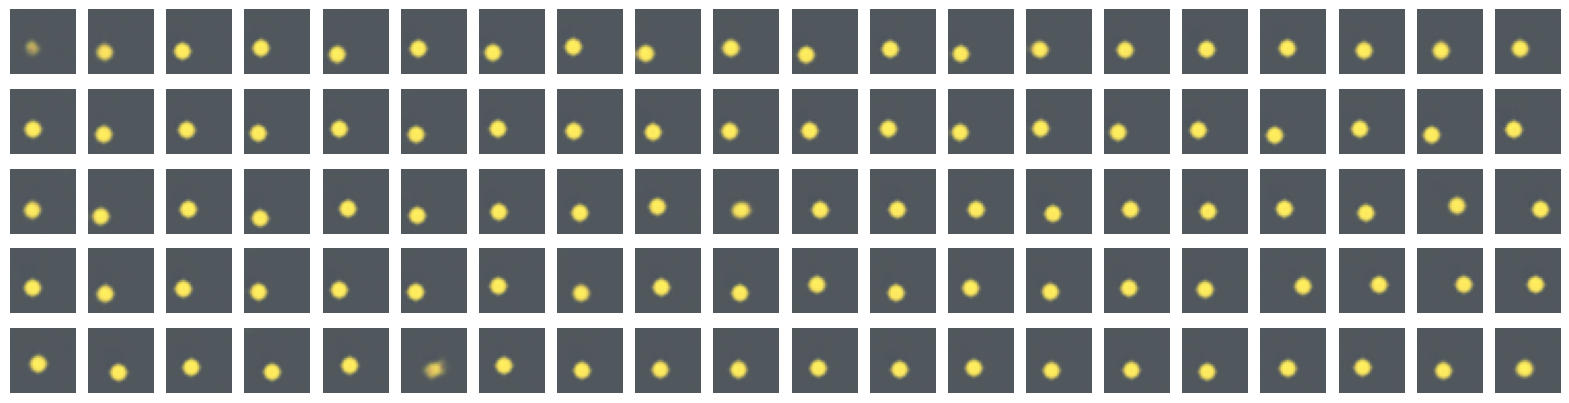

In [27]:
# Create samples

n_samples = 5
t = 20
model.eval()
with torch.inference_mode():
    s = model.sample(seq_len = t, n_samples=n_samples)
    s = s.cpu().numpy()
 
imshow_grid(s-0.5, n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)      

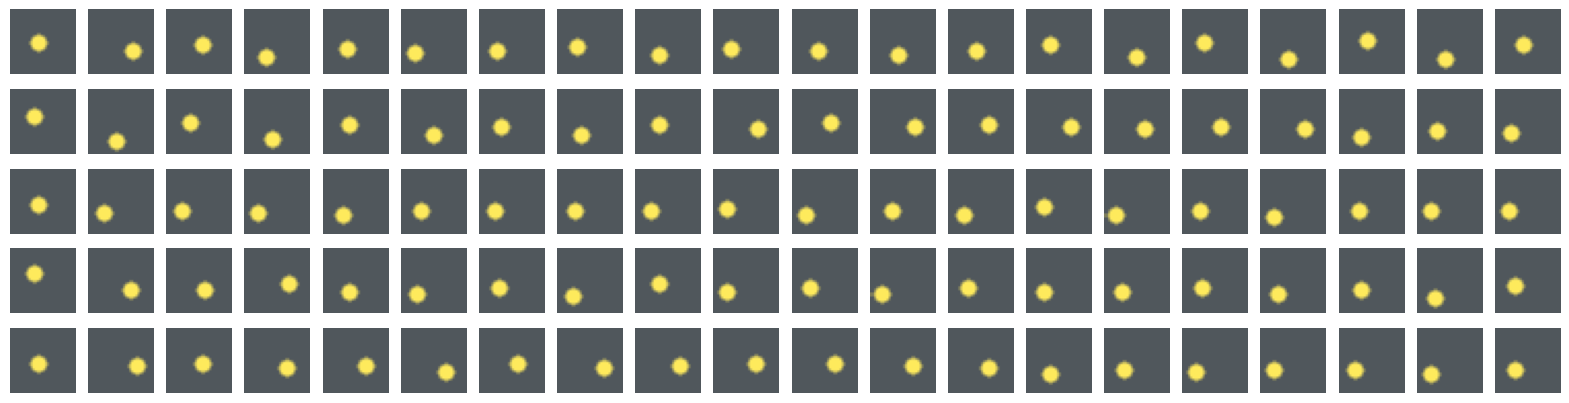

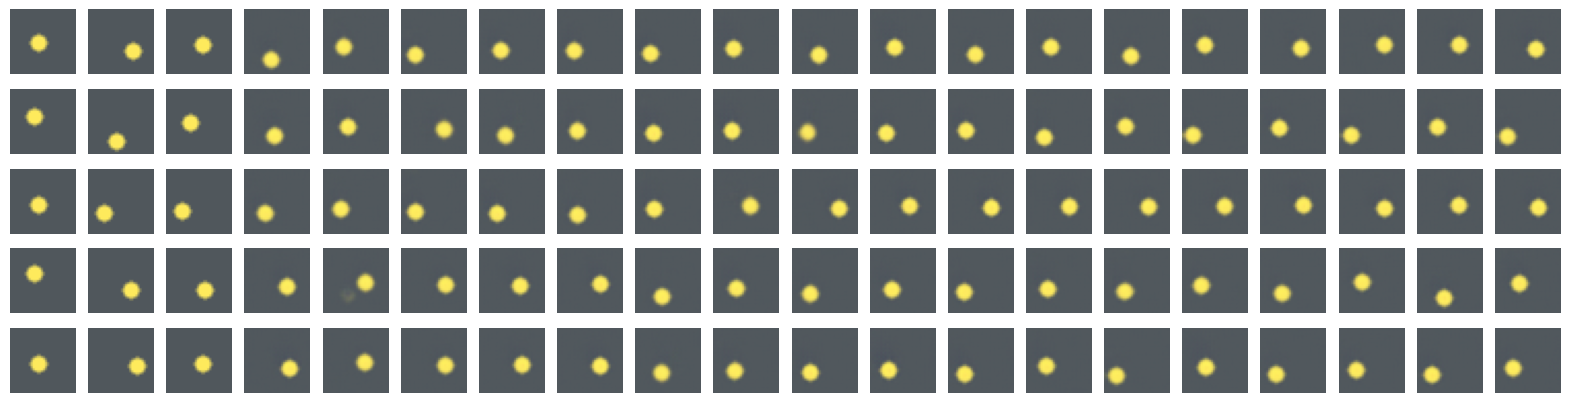

In [30]:
# Predictions

with torch.inference_mode():
    x = next(iter(test_dataloader))[0]
    x = (x.float().to(device))
    x = x + 0.5
    B = x.shape[0]
    preds = model.predict_sequence(x[:,:3], seq_len=17).cpu()
    x = x.cpu()
    preds = torch.cat((x[:,:3],preds),dim=1).cpu().numpy()
    x = x.numpy()

imshow_grid((x[:5]-0.5), n_row=5, n_col=20, fig_size_a=20, fig_size_b=5)
imshow_grid((preds[:5]-0.5), n_row=5, n_col=20, fig_size_a=20, fig_size_b=5)


In [31]:
with torch.inference_mode():
    predict_mse = []
    for sample in test_dataloader:
        mse_values = []
        sample = sample[0]
        B, T, C, H, W = sample.size()
        obs_var = sample.float().to(device)
        obs_var = obs_var + 0.5
        preds = model.predict_sequence(obs_var[:,:3], seq_len=T-3)
        obs_var, preds = obs_var.cpu().numpy(), preds.cpu().reshape(B, (T-3), C, H, W).numpy()
        mse = np.mean(((preds - obs_var[:,3:]) ** 2),axis=(0,2,3,4))
        mse_values.append(mse)
    mse_val = sum(mse_values) / len(mse_values)
    predict_mse.append(mse_val.tolist())

In [32]:
predict_mse[0]

[0.004772608168423176,
 0.007380708120763302,
 0.00884187314659357,
 0.010385964065790176,
 0.012670652009546757,
 0.011145314201712608,
 0.012673022225499153,
 0.01258794404566288,
 0.012751945294439793,
 0.01155307237058878,
 0.013295946642756462,
 0.012649411335587502,
 0.012581895105540752,
 0.012580526061356068,
 0.013959755189716816,
 0.013228006660938263,
 0.013462357223033905]

([<matplotlib.axis.XTick at 0x768740e2e320>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16')])

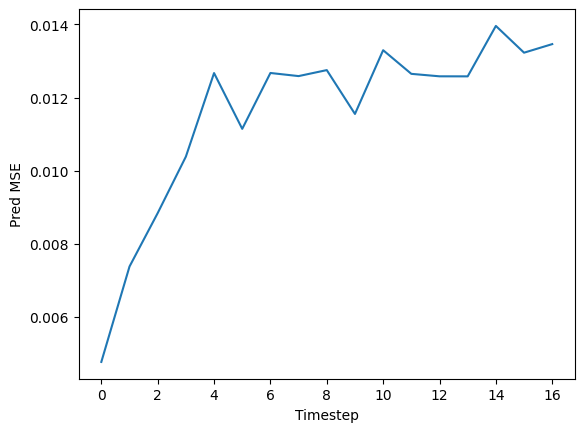

In [33]:
plt.plot(predict_mse[0])
plt.xlabel('Timestep')
plt.ylabel('Pred MSE')
plt.xticks(np.arange(0,18,2))

In [34]:
# Check ELBO,IWAE,FIVO values
# We expect FIVO<IWAE<ELBO

with torch.inference_mode():
    elbo_list = []
    iwae_list = []
    fivo_list = []
    for sample in tqdm.tqdm(train_dataloader):
        obs_var = sample[0].float().to(device)
        obs_var = obs_var + 0.5
        elbo, _ = model(obs_var)
        iwae, _ = model.iwae(obs_var, 10)
        fivo, _ = model.fivo(obs_var, 10)
        iwae = -iwae
        fivo = -fivo
        elbo_list.append(elbo)
        iwae_list.append(iwae)
        fivo_list.append(fivo)
    print(f"ELBO: {sum(elbo_list)/len(elbo_list):.0f}")
    print(f"IWAE: {sum(iwae_list)/len(iwae_list):.0f}")
    print(f"FIVO: {sum(fivo_list)/len(fivo_list):.0f}")

100%|██████████| 157/157 [01:16<00:00,  2.04it/s]

ELBO: 206
IWAE: 139
FIVO: 76
